In [1]:
import importlib
import os
import json
import shutil
from pathlib import Path
import pandas as pd
from ray import tune
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.integration.keras import TuneReportCallback
from ray.air import session
import tensorflow as tf
import yaml

import utils, model_zoo, hominid

2023-06-01 15:30:18.831958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 15:30:19.766362: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-01 15:30:19.766440: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-01 15:30:19.766446: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
importlib.reload(hominid)

<module 'hominid' from '/home/chandana/projects/hominid_pipeline/hominid.py'>

In [16]:
working_dir = "/home/chandana/projects/hominid_pipeline/results"

In [39]:
hits = [
"experiments/sweeps/tune_hominid_8f34a_00085_85_conv1_activation=exponential,conv1_attention_pool_size=23,conv1_batchnorm=True,conv1_channel_weight=se_2023-05-18_00-04-12",
"experiments/sweeps/tune_hominid_8f34a_00185_185_conv1_activation=relu,conv1_attention_pool_size=23,conv1_batchnorm=True,conv1_channel_weight=softconv_2023-05-18_06-11-38",
"experiments/model_variations/tune_hominid_8f34a_00058_58_conv1_activation=relu,conv1_attention_pool_size=30,conv1_batchnorm=False,conv1_channel_weight=softconv_2023-05-17_22-09-59/exponential", # this one!
"experiments/model_variations/tune_hominid_8f34a_00056_56_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=se,conv1__2023-05-17_22-05-53/exponential",
"experiments/model_variations/tune_hominid_8f34a_00058_58_conv1_activation=relu,conv1_attention_pool_size=30,conv1_batchnorm=False,conv1_channel_weight=softconv_2023-05-17_22-09-59/exponential/variations/variation_1"    
]

In [ ]:
index = 2
config_file = f"{working_dir}/{hits[index]}/config.yaml"
config = hominid.load_config(config_file)

variation_index = 1
save_path = f"{working_dir}/{hits[index]}/variations/variation_{variation_index}"
utils.make_directory(save_path)


config = {
    'conv1_activation': 'exponential',
    'conv1_attention_pool_size': 30,
    'conv1_batchnorm': True,
    'conv1_channel_weight': 'softconv',
    'conv1_dropout': 0.3,
    'conv1_filters': 128,
    'conv1_kernel_size': 15,
    'conv1_max_pool': 8,
    'conv1_pool_type': 'max_pool',
    'conv1_type': 'pw',
    'dense_activation': 'relu',
    'dense_batchnorm': True,
    'dense_dropout': [0.4, 0.4],
    'dense_units': [128, 128],
    'input_shape': (249, 4),
    'mha_d_model': 96,
    'mha_dropout': 0.1,
    'mha_head_type': 'pool',
    'mha_heads': 8,
    'mha_layernorm': False,
    'output_activation': 'linear',
    'output_shape': 2,
    'softconv_filters': 96 # exploring the smaller softconv filter number
}

# need to reduce the number of the filters in the 1 by 1 conv!

tuner = hominid.HominidTuner(config, epochs=100, tuning_mode=False, save_path=save_path, subsample=False)
tuner.execute()

Input shape: (402296, 249, 4). Output shape: 2
Building model...


2023-06-01 15:30:53.361760: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 15:30:53.858045: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14239 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:81:00.0, compute capability: 8.6


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 249, 4)]     0           []                               
                                                                                                  
 pairwise_conv1d (PairwiseConv1  (None, 249, 128)    234368      ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 249, 128)     512         ['pairwise_conv1d[0][0]']        
                                                                                                  
 conv1_activation (Activation)  (None, 249, 128)     0           ['conv1_bn[0][0]']           

2023-06-01 15:30:59.392669: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-01 15:30:59.915675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-06-01 15:31:00.585729: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x56266410e150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-01 15:31:00.585790: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2023-06-01 15:31:00.594015: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-01 15:31:00.718202: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

3143/3143 [==============================] - 74s 22ms/step - loss: 2.4194 - Spearman: 0.4455 - pearson_r: 0.3516 - val_loss: 2.2088 - val_Spearman: 0.5215 - val_pearson_r: 0.3957 - lr: 0.0010
Epoch 2/100
3143/3143 [==============================] - 68s 22ms/step - loss: 2.1603 - Spearman: 0.5593 - pearson_r: 0.4757 - val_loss: 2.2089 - val_Spearman: 0.5323 - val_pearson_r: 0.4255 - lr: 0.0010
Epoch 3/100
3143/3143 [==============================] - 68s 22ms/step - loss: 2.2868 - Spearman: 0.5605 - pearson_r: 0.4733 - val_loss: 2.2980 - val_Spearman: 0.5448 - val_pearson_r: 0.4192 - lr: 0.0010
Epoch 4/100
3141/3143 [============================>.] - ETA: 0s - loss: 2.3288 - Spearman: 0.5620 - pearson_r: 0.4733
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
3143/3143 [==============================] - 68s 22ms/step - loss: 2.3287 - Spearman: 0.5619 - pearson_r: 0.4734 - val_loss: 2.3281 - val_Spearman: 0.5323 - val_pearson_r: 0.4208 - lr: 0.0010
Epoch 5/100


Epoch 39/100
3143/3143 [==============================] - 69s 22ms/step - loss: 1.8994 - Spearman: 0.6079 - pearson_r: 0.5662 - val_loss: 1.8581 - val_Spearman: 0.5757 - val_pearson_r: 0.4908 - lr: 4.0000e-05
Epoch 40/100
3143/3143 [==============================] - 69s 22ms/step - loss: 1.8876 - Spearman: 0.6092 - pearson_r: 0.5691 - val_loss: 1.8476 - val_Spearman: 0.5785 - val_pearson_r: 0.4915 - lr: 4.0000e-05
Epoch 41/100
3143/3143 [==============================] - 69s 22ms/step - loss: 1.8775 - Spearman: 0.6104 - pearson_r: 0.5715 - val_loss: 1.8369 - val_Spearman: 0.5796 - val_pearson_r: 0.4941 - lr: 4.0000e-05
Epoch 42/100
3143/3143 [==============================] - 69s 22ms/step - loss: 1.8654 - Spearman: 0.6110 - pearson_r: 0.5753 - val_loss: 1.8265 - val_Spearman: 0.5783 - val_pearson_r: 0.4956 - lr: 4.0000e-05
Epoch 43/100
3143/3143 [==============================] - 69s 22ms/step - loss: 1.8576 - Spearman: 0.6116 - pearson_r: 0.5770 - val_loss: 1.8237 - val_Spearman: 0.5

In [11]:
print(tuner.get_evaluation_results()[["PCC_dev", "PCC_hk"]])

    PCC_dev    PCC_hk
0  0.567883  0.688507


In [9]:
config

{'conv1_activation': 'exponential',
 'conv1_attention_pool_size': 30,
 'conv1_batchnorm': True,
 'conv1_channel_weight': 'softconv',
 'conv1_dropout': 0.3,
 'conv1_filters': 128,
 'conv1_kernel_size': 15,
 'conv1_max_pool': 8,
 'conv1_pool_type': 'max_pool',
 'conv1_type': 'pw',
 'dense_activation': 'relu',
 'dense_batchnorm': True,
 'dense_dropout': [0.4, 0.4],
 'dense_units': [128, 128],
 'input_shape': (249, 4),
 'mha_d_model': 96,
 'mha_dropout': 0.1,
 'mha_head_type': 'pool',
 'mha_heads': 8,
 'mha_layernorm': False,
 'output_activation': 'linear',
 'output_shape': 2,
 'softconv_filters': 96}

In [18]:
config

{'conv1_activation': 'exponential',
 'conv1_attention_pool_size': 5,
 'conv1_batchnorm': True,
 'conv1_channel_weight': 'se',
 'conv1_dropout': 0.3,
 'conv1_filters': 256,
 'conv1_kernel_size': 15,
 'conv1_max_pool': 8,
 'conv1_pool_type': 'attention',
 'conv1_type': 'pw',
 'dense_activation': 'relu',
 'dense_batchnorm': True,
 'dense_dropout': [0.3, 0.3],
 'dense_units': [256, 128],
 'input_shape': (249, 4),
 'mha_d_model': 192,
 'mha_dropout': 0.1,
 'mha_head_type': 'task_specific',
 'mha_heads': 4,
 'mha_layernorm': False,
 'output_activation': 'linear',
 'output_shape': 2}

In [ ]:
"model_variations/tune_hominid_8f34a_00058_58_conv1_activation=relu,conv1_attention_pool_size=30,conv1_batchnorm=False,conv1_channel_weight=softconv_2023-05-17_22-09-59/exponential/variations/variation_1"

In [43]:
data = []
for index in range(len(hits)):
    
    config_file = f"{working_dir}/{hits[index]}/config.yaml"
    print(config_file)
    print()
    config = hominid.load_config(config_file)
    
    save_path = config_file.split("config.yaml")[0][:-1]
    tuner = hominid.HominidTuner(config, epochs=1, tuning_mode=False, save_path=save_path)
    df = tuner.get_evaluation_results()
#     print(df[["PCC_dev", "PCC_hk"]])

    for key in config:
    
        config[key] = [config[key]]

    config["PCC_dev"] = df["PCC_dev"].to_list()
    config["PCC_hk"] = df["PCC_hk"].to_list()    
    if "softconv_filters" not in config:
        config["softconv_filters"] = 128
    frame = pd.DataFrame(config)
    
    data += [frame]

/home/chandana/projects/hominid_pipeline/results/experiments/sweeps/tune_hominid_8f34a_00085_85_conv1_activation=exponential,conv1_attention_pool_size=23,conv1_batchnorm=True,conv1_channel_weight=se_2023-05-18_00-04-12/config.yaml

/home/chandana/projects/hominid_pipeline/results/experiments/sweeps/tune_hominid_8f34a_00185_185_conv1_activation=relu,conv1_attention_pool_size=23,conv1_batchnorm=True,conv1_channel_weight=softconv_2023-05-18_06-11-38/config.yaml

/home/chandana/projects/hominid_pipeline/results/experiments/model_variations/tune_hominid_8f34a_00058_58_conv1_activation=relu,conv1_attention_pool_size=30,conv1_batchnorm=False,conv1_channel_weight=softconv_2023-05-17_22-09-59/exponential/config.yaml

/home/chandana/projects/hominid_pipeline/results/experiments/model_variations/tune_hominid_8f34a_00056_56_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=se,conv1__2023-05-17_22-05-53/exponential/config.yaml

/home/chandana/projects/homi

In [26]:
df["PCC_dev"].to_list()

[0.6911514239319214]

In [44]:
df = pd.concat(data, axis=0).reset_index().drop(columns=["index"])
df

,conv1_activation,conv1_attention_pool_size,conv1_batchnorm,conv1_channel_weight,conv1_dropout,conv1_filters,conv1_kernel_size,conv1_max_pool,conv1_pool_type,conv1_type,...,mha_d_model,mha_dropout,mha_head_type,mha_heads,mha_layernorm,output_activation,output_shape,PCC_dev,PCC_hk,softconv_filters
0,exponential,23,True,se,0.1,256,11,0,max_pool,pw,...,96,0.0,task_specific,8,False,linear,2,0.692897,0.765001,128
1,relu,23,True,softconv,0.3,96,19,8,max_pool,standard,...,192,0.2,pool,4,False,linear,2,0.687367,0.769976,128
2,exponential,30,True,softconv,0.3,128,15,8,max_pool,pw,...,96,0.1,pool,8,False,linear,2,0.542731,0.669031,128
3,exponential,5,True,se,0.3,256,15,8,attention,pw,...,192,0.1,task_specific,4,False,linear,2,0.691151,0.767116,128
4,exponential,30,True,softconv,0.3,128,15,8,max_pool,pw,...,96,0.1,pool,8,False,linear,2,0.567883,0.688507,96


In [45]:
df.T # nened to reorganize by relevance

,0,1,2,3,4
conv1_activation,exponential,relu,exponential,exponential,exponential
conv1_attention_pool_size,23,23,30,5,30
conv1_batchnorm,True,True,True,True,True
conv1_channel_weight,se,softconv,softconv,se,softconv
conv1_dropout,0.1,0.3,0.3,0.3,0.3
conv1_filters,256,96,128,256,128
conv1_kernel_size,11,19,15,15,15
conv1_max_pool,0,8,8,8,8
conv1_pool_type,max_pool,max_pool,max_pool,attention,max_pool
conv1_type,pw,standard,pw,pw,pw


# Interpret the model

Loading model and dataset!
Building model...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 249, 4)]     0           []                               
                                                                                                  
 pairwise_conv1d (PairwiseConv1  (None, 249, 128)    234368      ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 249, 128)     512         ['pairwise_conv1d[0][0]']        
                                                                                                  
 conv1_activation (Activation)  (None, 249, 128)     0           ['conv1_bn[0][0]']           

  0%|                                                                                                                                         | 0/643 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|▏                                                                                                                                | 1/643 [00:00<01:37,  6.57it/s]

2/2 [==============================] - 0s 2ms/step


  0%|▌                                                                                                                                | 3/643 [00:00<00:56, 11.37it/s]

2/2 [==============================] - 0s 2ms/step


  1%|█                                                                                                                                | 5/643 [00:00<00:49, 12.95it/s]

2/2 [==============================] - 0s 2ms/step


  1%|█▍                                                                                                                               | 7/643 [00:00<00:46, 13.82it/s]

2/2 [==============================] - 0s 2ms/step


  1%|█▊                                                                                                                               | 9/643 [00:00<00:43, 14.51it/s]

2/2 [==============================] - 0s 2ms/step


  2%|██▏                                                                                                                             | 11/643 [00:00<00:42, 14.71it/s]

2/2 [==============================] - 0s 2ms/step


  2%|██▌                                                                                                                             | 13/643 [00:00<00:41, 15.12it/s]

2/2 [==============================] - 0s 2ms/step


  2%|██▉                                                                                                                             | 15/643 [00:01<00:40, 15.42it/s]

2/2 [==============================] - 0s 3ms/step


  3%|███▍                                                                                                                            | 17/643 [00:01<00:41, 15.21it/s]

2/2 [==============================] - 0s 2ms/step


  3%|███▊                                                                                                                            | 19/643 [00:01<00:40, 15.39it/s]

2/2 [==============================] - 0s 3ms/step


  3%|████▏                                                                                                                           | 21/643 [00:01<00:40, 15.47it/s]

2/2 [==============================] - 0s 2ms/step


  4%|████▌                                                                                                                           | 23/643 [00:01<00:40, 15.49it/s]

2/2 [==============================] - 0s 2ms/step


  4%|████▉                                                                                                                           | 25/643 [00:01<00:40, 15.40it/s]

2/2 [==============================] - 0s 3ms/step


  4%|█████▎                                                                                                                          | 27/643 [00:01<00:40, 15.03it/s]

2/2 [==============================] - 0s 2ms/step


  5%|█████▊                                                                                                                          | 29/643 [00:01<00:40, 15.14it/s]

2/2 [==============================] - 0s 2ms/step


  5%|██████▏                                                                                                                         | 31/643 [00:02<00:39, 15.38it/s]

2/2 [==============================] - 0s 3ms/step


  5%|██████▌                                                                                                                         | 33/643 [00:02<00:40, 14.91it/s]

2/2 [==============================] - 0s 3ms/step


  5%|██████▉                                                                                                                         | 35/643 [00:02<00:42, 14.35it/s]

2/2 [==============================] - 0s 2ms/step


  6%|███████▎                                                                                                                        | 37/643 [00:02<00:42, 14.18it/s]

2/2 [==============================] - 0s 2ms/step


  6%|███████▊                                                                                                                        | 39/643 [00:02<00:41, 14.57it/s]

2/2 [==============================] - 0s 3ms/step


  6%|████████▏                                                                                                                       | 41/643 [00:02<00:41, 14.61it/s]

2/2 [==============================] - 0s 2ms/step


  7%|████████▌                                                                                                                       | 43/643 [00:02<00:40, 14.69it/s]

2/2 [==============================] - 0s 3ms/step


  7%|████████▉                                                                                                                       | 45/643 [00:03<00:40, 14.91it/s]

2/2 [==============================] - 0s 2ms/step


  7%|█████████▎                                                                                                                      | 47/643 [00:03<00:40, 14.87it/s]

2/2 [==============================] - 0s 2ms/step


  8%|█████████▊                                                                                                                      | 49/643 [00:03<00:39, 15.01it/s]

2/2 [==============================] - 0s 2ms/step


  8%|██████████▏                                                                                                                     | 51/643 [00:03<00:39, 14.97it/s]

2/2 [==============================] - 0s 2ms/step


  8%|██████████▌                                                                                                                     | 53/643 [00:03<00:38, 15.17it/s]

2/2 [==============================] - 0s 2ms/step


  9%|██████████▉                                                                                                                     | 55/643 [00:03<00:39, 15.03it/s]

2/2 [==============================] - 0s 2ms/step


  9%|███████████▎                                                                                                                    | 57/643 [00:03<00:38, 15.24it/s]

2/2 [==============================] - 0s 2ms/step


  9%|███████████▋                                                                                                                    | 59/643 [00:03<00:37, 15.42it/s]

2/2 [==============================] - 0s 2ms/step


  9%|████████████▏                                                                                                                   | 61/643 [00:04<00:37, 15.47it/s]

2/2 [==============================] - 0s 2ms/step


 10%|████████████▌                                                                                                                   | 63/643 [00:04<00:37, 15.65it/s]

2/2 [==============================] - 0s 2ms/step


 10%|████████████▉                                                                                                                   | 65/643 [00:04<00:38, 15.19it/s]

2/2 [==============================] - 0s 2ms/step


 10%|█████████████▎                                                                                                                  | 67/643 [00:04<00:37, 15.43it/s]

2/2 [==============================] - 0s 2ms/step


 11%|█████████████▋                                                                                                                  | 69/643 [00:04<00:36, 15.59it/s]

2/2 [==============================] - 0s 2ms/step


 11%|██████████████▏                                                                                                                 | 71/643 [00:04<00:36, 15.73it/s]

2/2 [==============================] - 0s 2ms/step


 11%|██████████████▌                                                                                                                 | 73/643 [00:04<00:36, 15.72it/s]

2/2 [==============================] - 0s 3ms/step


 12%|██████████████▉                                                                                                                 | 75/643 [00:05<00:36, 15.36it/s]

2/2 [==============================] - 0s 2ms/step


 12%|███████████████▎                                                                                                                | 77/643 [00:05<00:36, 15.40it/s]

2/2 [==============================] - 0s 2ms/step


 12%|███████████████▋                                                                                                                | 79/643 [00:05<00:35, 15.69it/s]

2/2 [==============================] - 0s 2ms/step


 13%|████████████████                                                                                                                | 81/643 [00:05<00:35, 15.79it/s]

2/2 [==============================] - 0s 2ms/step


 13%|████████████████▌                                                                                                               | 83/643 [00:05<00:34, 16.12it/s]

2/2 [==============================] - 0s 3ms/step


 13%|████████████████▉                                                                                                               | 85/643 [00:05<00:34, 16.00it/s]

2/2 [==============================] - 0s 2ms/step


 14%|█████████████████▎                                                                                                              | 87/643 [00:05<00:34, 16.17it/s]

2/2 [==============================] - 0s 2ms/step


 14%|█████████████████▋                                                                                                              | 89/643 [00:05<00:33, 16.34it/s]

2/2 [==============================] - 0s 2ms/step


 14%|██████████████████                                                                                                              | 91/643 [00:05<00:33, 16.55it/s]

2/2 [==============================] - 0s 2ms/step


 14%|██████████████████▌                                                                                                             | 93/643 [00:06<00:32, 16.77it/s]

2/2 [==============================] - 0s 2ms/step


 15%|██████████████████▉                                                                                                             | 95/643 [00:06<00:33, 16.44it/s]

2/2 [==============================] - 0s 2ms/step


 15%|███████████████████▎                                                                                                            | 97/643 [00:06<00:33, 16.47it/s]

2/2 [==============================] - 0s 2ms/step


 15%|███████████████████▋                                                                                                            | 99/643 [00:06<00:32, 16.72it/s]

2/2 [==============================] - 0s 2ms/step


 16%|███████████████████▉                                                                                                           | 101/643 [00:06<00:32, 16.77it/s]

2/2 [==============================] - 0s 2ms/step


 16%|████████████████████▎                                                                                                          | 103/643 [00:06<00:31, 16.97it/s]

2/2 [==============================] - 0s 2ms/step


 16%|████████████████████▋                                                                                                          | 105/643 [00:06<00:32, 16.67it/s]

2/2 [==============================] - 0s 2ms/step


 17%|█████████████████████▏                                                                                                         | 107/643 [00:06<00:31, 16.78it/s]

2/2 [==============================] - 0s 2ms/step


 17%|█████████████████████▌                                                                                                         | 109/643 [00:07<00:31, 16.96it/s]

2/2 [==============================] - 0s 2ms/step


 17%|█████████████████████▉                                                                                                         | 111/643 [00:07<00:31, 16.94it/s]

2/2 [==============================] - 0s 2ms/step


 18%|██████████████████████▎                                                                                                        | 113/643 [00:07<00:30, 17.12it/s]

2/2 [==============================] - 0s 2ms/step


 18%|██████████████████████▋                                                                                                        | 115/643 [00:07<00:31, 16.83it/s]

2/2 [==============================] - 0s 2ms/step


 18%|███████████████████████                                                                                                        | 117/643 [00:07<00:31, 16.91it/s]

2/2 [==============================] - 0s 2ms/step


 19%|███████████████████████▌                                                                                                       | 119/643 [00:07<00:30, 17.02it/s]

2/2 [==============================] - 0s 2ms/step


 19%|███████████████████████▉                                                                                                       | 121/643 [00:07<00:30, 17.17it/s]

2/2 [==============================] - 0s 2ms/step


 19%|████████████████████████▎                                                                                                      | 123/643 [00:07<00:30, 17.22it/s]

2/2 [==============================] - 0s 2ms/step


 19%|████████████████████████▋                                                                                                      | 125/643 [00:08<00:30, 16.79it/s]

2/2 [==============================] - 0s 2ms/step


 20%|█████████████████████████                                                                                                      | 127/643 [00:08<00:30, 16.84it/s]

2/2 [==============================] - 0s 2ms/step


 20%|█████████████████████████▍                                                                                                     | 129/643 [00:08<00:30, 16.85it/s]

2/2 [==============================] - 0s 2ms/step


 20%|█████████████████████████▊                                                                                                     | 131/643 [00:08<00:30, 16.98it/s]

2/2 [==============================] - 0s 2ms/step


 21%|██████████████████████████▎                                                                                                    | 133/643 [00:08<00:29, 17.16it/s]

2/2 [==============================] - 0s 2ms/step


 21%|██████████████████████████▋                                                                                                    | 135/643 [00:08<00:30, 16.71it/s]

2/2 [==============================] - 0s 3ms/step


 21%|███████████████████████████                                                                                                    | 137/643 [00:08<00:30, 16.48it/s]

2/2 [==============================] - 0s 2ms/step


 22%|███████████████████████████▍                                                                                                   | 139/643 [00:08<00:30, 16.53it/s]

2/2 [==============================] - 0s 2ms/step


 22%|███████████████████████████▊                                                                                                   | 141/643 [00:08<00:31, 15.94it/s]

2/2 [==============================] - 0s 2ms/step


 22%|████████████████████████████▏                                                                                                  | 143/643 [00:09<00:30, 16.35it/s]

2/2 [==============================] - 0s 2ms/step


 23%|████████████████████████████▋                                                                                                  | 145/643 [00:09<00:30, 16.38it/s]

2/2 [==============================] - 0s 2ms/step


 23%|█████████████████████████████                                                                                                  | 147/643 [00:09<00:29, 16.60it/s]

2/2 [==============================] - 0s 2ms/step


 23%|█████████████████████████████▍                                                                                                 | 149/643 [00:09<00:29, 16.72it/s]

2/2 [==============================] - 0s 2ms/step


 23%|█████████████████████████████▊                                                                                                 | 151/643 [00:09<00:29, 16.73it/s]

2/2 [==============================] - 0s 2ms/step


 24%|██████████████████████████████▏                                                                                                | 153/643 [00:09<00:30, 16.22it/s]

2/2 [==============================] - 0s 2ms/step


 24%|██████████████████████████████▌                                                                                                | 155/643 [00:09<00:30, 15.82it/s]

2/2 [==============================] - 0s 3ms/step


 24%|███████████████████████████████                                                                                                | 157/643 [00:09<00:31, 15.65it/s]

2/2 [==============================] - 0s 2ms/step


 25%|███████████████████████████████▍                                                                                               | 159/643 [00:10<00:30, 15.82it/s]

2/2 [==============================] - 0s 3ms/step


 25%|███████████████████████████████▊                                                                                               | 161/643 [00:10<00:29, 16.13it/s]

2/2 [==============================] - 0s 2ms/step


 25%|████████████████████████████████▏                                                                                              | 163/643 [00:10<00:29, 16.43it/s]

2/2 [==============================] - 0s 2ms/step


 26%|████████████████████████████████▌                                                                                              | 165/643 [00:10<00:29, 16.39it/s]

2/2 [==============================] - 0s 2ms/step


 26%|████████████████████████████████▉                                                                                              | 167/643 [00:10<00:28, 16.57it/s]

2/2 [==============================] - 0s 2ms/step


 26%|█████████████████████████████████▍                                                                                             | 169/643 [00:10<00:28, 16.60it/s]

2/2 [==============================] - 0s 2ms/step


 27%|█████████████████████████████████▊                                                                                             | 171/643 [00:10<00:28, 16.76it/s]

2/2 [==============================] - 0s 2ms/step


 27%|██████████████████████████████████▏                                                                                            | 173/643 [00:10<00:31, 14.96it/s]

2/2 [==============================] - 0s 2ms/step


 27%|██████████████████████████████████▌                                                                                            | 175/643 [00:11<00:31, 14.66it/s]

2/2 [==============================] - 0s 2ms/step


 28%|██████████████████████████████████▉                                                                                            | 177/643 [00:11<00:30, 15.13it/s]

2/2 [==============================] - 0s 2ms/step


 28%|███████████████████████████████████▎                                                                                           | 179/643 [00:11<00:29, 15.59it/s]

2/2 [==============================] - 0s 2ms/step


 28%|███████████████████████████████████▋                                                                                           | 181/643 [00:11<00:28, 16.10it/s]

2/2 [==============================] - 0s 2ms/step


 28%|████████████████████████████████████▏                                                                                          | 183/643 [00:11<00:27, 16.46it/s]

2/2 [==============================] - 0s 2ms/step


 29%|████████████████████████████████████▌                                                                                          | 185/643 [00:11<00:28, 16.19it/s]

2/2 [==============================] - 0s 2ms/step


 29%|████████████████████████████████████▉                                                                                          | 187/643 [00:11<00:27, 16.46it/s]

2/2 [==============================] - 0s 2ms/step


 29%|█████████████████████████████████████▎                                                                                         | 189/643 [00:11<00:27, 16.71it/s]

2/2 [==============================] - 0s 2ms/step


 30%|█████████████████████████████████████▋                                                                                         | 191/643 [00:12<00:27, 16.74it/s]

2/2 [==============================] - 0s 2ms/step


 30%|██████████████████████████████████████                                                                                         | 193/643 [00:12<00:26, 16.91it/s]

2/2 [==============================] - 0s 3ms/step


 30%|██████████████████████████████████████▌                                                                                        | 195/643 [00:12<00:27, 16.36it/s]

2/2 [==============================] - 0s 2ms/step


 31%|██████████████████████████████████████▉                                                                                        | 197/643 [00:12<00:27, 16.18it/s]

2/2 [==============================] - 0s 2ms/step


 31%|███████████████████████████████████████▎                                                                                       | 199/643 [00:12<00:27, 16.39it/s]

2/2 [==============================] - 0s 2ms/step


 31%|███████████████████████████████████████▋                                                                                       | 201/643 [00:12<00:26, 16.77it/s]

2/2 [==============================] - 0s 2ms/step


 32%|████████████████████████████████████████                                                                                       | 203/643 [00:12<00:26, 16.83it/s]

2/2 [==============================] - 0s 2ms/step


 32%|████████████████████████████████████████▍                                                                                      | 205/643 [00:12<00:26, 16.61it/s]

2/2 [==============================] - 0s 2ms/step


 32%|████████████████████████████████████████▉                                                                                      | 207/643 [00:13<00:26, 16.52it/s]

2/2 [==============================] - 0s 2ms/step


 33%|█████████████████████████████████████████▎                                                                                     | 209/643 [00:13<00:25, 16.76it/s]

2/2 [==============================] - 0s 2ms/step


 33%|█████████████████████████████████████████▋                                                                                     | 211/643 [00:13<00:25, 16.80it/s]

2/2 [==============================] - 0s 2ms/step


 33%|██████████████████████████████████████████                                                                                     | 213/643 [00:13<00:25, 16.90it/s]

2/2 [==============================] - 0s 2ms/step


 33%|██████████████████████████████████████████▍                                                                                    | 215/643 [00:13<00:25, 16.76it/s]

2/2 [==============================] - 0s 2ms/step


 34%|██████████████████████████████████████████▊                                                                                    | 217/643 [00:13<00:27, 15.71it/s]

2/2 [==============================] - 0s 2ms/step


 34%|███████████████████████████████████████████▎                                                                                   | 219/643 [00:13<00:26, 16.09it/s]

2/2 [==============================] - 0s 2ms/step


 34%|███████████████████████████████████████████▋                                                                                   | 221/643 [00:13<00:25, 16.36it/s]

2/2 [==============================] - 0s 2ms/step


 35%|████████████████████████████████████████████                                                                                   | 223/643 [00:14<00:26, 16.10it/s]

2/2 [==============================] - 0s 2ms/step


 35%|████████████████████████████████████████████▍                                                                                  | 225/643 [00:14<00:26, 16.03it/s]

2/2 [==============================] - 0s 2ms/step


 35%|████████████████████████████████████████████▊                                                                                  | 227/643 [00:14<00:25, 16.34it/s]

2/2 [==============================] - 0s 5ms/step


 36%|█████████████████████████████████████████████▏                                                                                 | 229/643 [00:14<00:25, 16.30it/s]

2/2 [==============================] - 0s 2ms/step


 36%|█████████████████████████████████████████████▋                                                                                 | 231/643 [00:14<00:24, 16.63it/s]

2/2 [==============================] - 0s 2ms/step


 36%|██████████████████████████████████████████████                                                                                 | 233/643 [00:14<00:24, 16.78it/s]

2/2 [==============================] - 0s 2ms/step


 37%|██████████████████████████████████████████████▍                                                                                | 235/643 [00:14<00:24, 16.47it/s]

2/2 [==============================] - 0s 2ms/step


 37%|██████████████████████████████████████████████▊                                                                                | 237/643 [00:14<00:24, 16.51it/s]

2/2 [==============================] - 0s 2ms/step


 37%|███████████████████████████████████████████████▏                                                                               | 239/643 [00:14<00:24, 16.72it/s]

2/2 [==============================] - 0s 2ms/step


 37%|███████████████████████████████████████████████▌                                                                               | 241/643 [00:15<00:23, 16.86it/s]

2/2 [==============================] - 0s 2ms/step


 38%|███████████████████████████████████████████████▉                                                                               | 243/643 [00:15<00:23, 16.98it/s]

2/2 [==============================] - 0s 2ms/step


 38%|████████████████████████████████████████████████▍                                                                              | 245/643 [00:15<00:23, 16.67it/s]

2/2 [==============================] - 0s 2ms/step


 38%|████████████████████████████████████████████████▊                                                                              | 247/643 [00:15<00:23, 16.53it/s]

2/2 [==============================] - 0s 2ms/step


 39%|█████████████████████████████████████████████████▏                                                                             | 249/643 [00:15<00:23, 16.74it/s]

2/2 [==============================] - 0s 2ms/step


 39%|█████████████████████████████████████████████████▌                                                                             | 251/643 [00:15<00:23, 16.91it/s]

2/2 [==============================] - 0s 2ms/step


 39%|█████████████████████████████████████████████████▉                                                                             | 253/643 [00:15<00:23, 16.81it/s]

2/2 [==============================] - 0s 2ms/step


 40%|██████████████████████████████████████████████████▎                                                                            | 255/643 [00:15<00:23, 16.60it/s]

2/2 [==============================] - 0s 2ms/step


 40%|██████████████████████████████████████████████████▊                                                                            | 257/643 [00:16<00:24, 15.57it/s]

2/2 [==============================] - 0s 2ms/step


 40%|███████████████████████████████████████████████████▏                                                                           | 259/643 [00:16<00:23, 16.04it/s]

2/2 [==============================] - 0s 2ms/step


 41%|███████████████████████████████████████████████████▌                                                                           | 261/643 [00:16<00:23, 16.24it/s]

2/2 [==============================] - 0s 2ms/step


 41%|███████████████████████████████████████████████████▉                                                                           | 263/643 [00:16<00:23, 16.43it/s]

2/2 [==============================] - 0s 2ms/step


 41%|████████████████████████████████████████████████████▎                                                                          | 265/643 [00:16<00:23, 16.38it/s]

2/2 [==============================] - 0s 2ms/step


 42%|████████████████████████████████████████████████████▋                                                                          | 267/643 [00:16<00:22, 16.60it/s]

2/2 [==============================] - 0s 2ms/step


 42%|█████████████████████████████████████████████████████▏                                                                         | 269/643 [00:16<00:22, 16.88it/s]

2/2 [==============================] - 0s 2ms/step


 42%|█████████████████████████████████████████████████████▌                                                                         | 271/643 [00:16<00:21, 16.93it/s]

2/2 [==============================] - 0s 3ms/step


 42%|█████████████████████████████████████████████████████▉                                                                         | 273/643 [00:17<00:23, 15.91it/s]

2/2 [==============================] - 0s 2ms/step


 43%|██████████████████████████████████████████████████████▎                                                                        | 275/643 [00:17<00:23, 15.91it/s]

2/2 [==============================] - 0s 2ms/step


 43%|██████████████████████████████████████████████████████▋                                                                        | 277/643 [00:17<00:22, 16.07it/s]

2/2 [==============================] - 0s 2ms/step


 43%|███████████████████████████████████████████████████████                                                                        | 279/643 [00:17<00:22, 16.46it/s]

2/2 [==============================] - 0s 2ms/step


 44%|███████████████████████████████████████████████████████▌                                                                       | 281/643 [00:17<00:21, 16.72it/s]

2/2 [==============================] - 0s 2ms/step


 44%|███████████████████████████████████████████████████████▉                                                                       | 283/643 [00:17<00:21, 16.62it/s]

2/2 [==============================] - 0s 2ms/step


 44%|████████████████████████████████████████████████████████▎                                                                      | 285/643 [00:17<00:21, 16.39it/s]

2/2 [==============================] - 0s 2ms/step


 45%|████████████████████████████████████████████████████████▋                                                                      | 287/643 [00:17<00:23, 15.32it/s]

2/2 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████████████████                                                                      | 289/643 [00:18<00:22, 15.79it/s]

2/2 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████████████████▍                                                                     | 291/643 [00:18<00:22, 15.76it/s]

2/2 [==============================] - 0s 2ms/step


 46%|█████████████████████████████████████████████████████████▊                                                                     | 293/643 [00:18<00:23, 14.72it/s]

2/2 [==============================] - 0s 2ms/step


 46%|██████████████████████████████████████████████████████████▎                                                                    | 295/643 [00:18<00:23, 15.03it/s]

2/2 [==============================] - 0s 2ms/step


 46%|██████████████████████████████████████████████████████████▋                                                                    | 297/643 [00:18<00:22, 15.65it/s]

2/2 [==============================] - 0s 2ms/step


 47%|███████████████████████████████████████████████████████████                                                                    | 299/643 [00:18<00:21, 16.17it/s]

2/2 [==============================] - 0s 2ms/step


 47%|███████████████████████████████████████████████████████████▍                                                                   | 301/643 [00:18<00:20, 16.52it/s]

2/2 [==============================] - 0s 2ms/step


 47%|███████████████████████████████████████████████████████████▊                                                                   | 303/643 [00:18<00:20, 16.66it/s]

2/2 [==============================] - 0s 2ms/step


 47%|████████████████████████████████████████████████████████████▏                                                                  | 305/643 [00:19<00:20, 16.34it/s]

2/2 [==============================] - 0s 3ms/step


 48%|████████████████████████████████████████████████████████████▋                                                                  | 307/643 [00:19<00:20, 16.19it/s]

2/2 [==============================] - 0s 3ms/step


 48%|█████████████████████████████████████████████████████████████                                                                  | 309/643 [00:19<00:20, 16.33it/s]

2/2 [==============================] - 0s 2ms/step


 48%|█████████████████████████████████████████████████████████████▍                                                                 | 311/643 [00:19<00:20, 16.47it/s]

2/2 [==============================] - 0s 3ms/step


 49%|█████████████████████████████████████████████████████████████▊                                                                 | 313/643 [00:19<00:23, 14.05it/s]

2/2 [==============================] - 0s 2ms/step


 49%|██████████████████████████████████████████████████████████████▏                                                                | 315/643 [00:19<00:22, 14.56it/s]

2/2 [==============================] - 0s 2ms/step


 49%|██████████████████████████████████████████████████████████████▌                                                                | 317/643 [00:19<00:21, 15.17it/s]

2/2 [==============================] - 0s 2ms/step


 50%|███████████████████████████████████████████████████████████████                                                                | 319/643 [00:19<00:20, 15.82it/s]

2/2 [==============================] - 0s 2ms/step


 50%|███████████████████████████████████████████████████████████████▍                                                               | 321/643 [00:20<00:20, 15.75it/s]

2/2 [==============================] - 0s 2ms/step


 50%|███████████████████████████████████████████████████████████████▊                                                               | 323/643 [00:20<00:19, 16.21it/s]

2/2 [==============================] - 0s 2ms/step


 51%|████████████████████████████████████████████████████████████████▏                                                              | 325/643 [00:20<00:19, 16.30it/s]

2/2 [==============================] - 0s 2ms/step


 51%|████████████████████████████████████████████████████████████████▌                                                              | 327/643 [00:20<00:20, 15.31it/s]

2/2 [==============================] - 0s 2ms/step


 51%|████████████████████████████████████████████████████████████████▉                                                              | 329/643 [00:20<00:19, 15.87it/s]

2/2 [==============================] - 0s 2ms/step


 51%|█████████████████████████████████████████████████████████████████▍                                                             | 331/643 [00:20<00:19, 16.18it/s]

2/2 [==============================] - 0s 2ms/step


 52%|█████████████████████████████████████████████████████████████████▊                                                             | 333/643 [00:20<00:18, 16.50it/s]

2/2 [==============================] - 0s 2ms/step


 52%|██████████████████████████████████████████████████████████████████▏                                                            | 335/643 [00:21<00:23, 13.16it/s]

2/2 [==============================] - 0s 2ms/step


 52%|██████████████████████████████████████████████████████████████████▌                                                            | 337/643 [00:21<00:21, 13.92it/s]

2/2 [==============================] - 0s 2ms/step


 53%|██████████████████████████████████████████████████████████████████▉                                                            | 339/643 [00:21<00:20, 14.70it/s]

2/2 [==============================] - 0s 3ms/step


 53%|███████████████████████████████████████████████████████████████████▎                                                           | 341/643 [00:21<00:20, 14.86it/s]

2/2 [==============================] - 0s 2ms/step


 53%|███████████████████████████████████████████████████████████████████▋                                                           | 343/643 [00:21<00:19, 15.38it/s]

2/2 [==============================] - 0s 2ms/step


 54%|████████████████████████████████████████████████████████████████████▏                                                          | 345/643 [00:21<00:19, 15.02it/s]

2/2 [==============================] - 0s 2ms/step


 54%|████████████████████████████████████████████████████████████████████▌                                                          | 347/643 [00:21<00:19, 15.29it/s]

2/2 [==============================] - 0s 2ms/step


 54%|████████████████████████████████████████████████████████████████████▉                                                          | 349/643 [00:21<00:18, 15.64it/s]

2/2 [==============================] - 0s 2ms/step


 55%|█████████████████████████████████████████████████████████████████████▎                                                         | 351/643 [00:22<00:18, 16.18it/s]

2/2 [==============================] - 0s 2ms/step


 55%|█████████████████████████████████████████████████████████████████████▋                                                         | 353/643 [00:22<00:17, 16.42it/s]

2/2 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████████████████████                                                         | 355/643 [00:22<00:17, 16.39it/s]

2/2 [==============================] - 0s 4ms/step


 56%|██████████████████████████████████████████████████████████████████████▌                                                        | 357/643 [00:22<00:17, 16.42it/s]

2/2 [==============================] - 0s 2ms/step


 56%|██████████████████████████████████████████████████████████████████████▉                                                        | 359/643 [00:22<00:17, 16.31it/s]

2/2 [==============================] - 0s 2ms/step


 56%|███████████████████████████████████████████████████████████████████████▎                                                       | 361/643 [00:22<00:17, 16.34it/s]

2/2 [==============================] - 0s 3ms/step


 56%|███████████████████████████████████████████████████████████████████████▋                                                       | 363/643 [00:22<00:17, 16.37it/s]

2/2 [==============================] - 0s 2ms/step


 57%|████████████████████████████████████████████████████████████████████████                                                       | 365/643 [00:22<00:17, 16.21it/s]

2/2 [==============================] - 0s 2ms/step


 57%|████████████████████████████████████████████████████████████████████████▍                                                      | 367/643 [00:23<00:16, 16.35it/s]

2/2 [==============================] - 0s 3ms/step


 57%|████████████████████████████████████████████████████████████████████████▉                                                      | 369/643 [00:23<00:17, 15.35it/s]

2/2 [==============================] - 0s 2ms/step


 58%|█████████████████████████████████████████████████████████████████████████▎                                                     | 371/643 [00:23<00:17, 15.56it/s]

2/2 [==============================] - 0s 3ms/step


 58%|█████████████████████████████████████████████████████████████████████████▋                                                     | 373/643 [00:23<00:17, 15.66it/s]

2/2 [==============================] - 0s 2ms/step


 58%|██████████████████████████████████████████████████████████████████████████                                                     | 375/643 [00:23<00:17, 15.75it/s]

2/2 [==============================] - 0s 2ms/step


 59%|██████████████████████████████████████████████████████████████████████████▍                                                    | 377/643 [00:23<00:16, 16.17it/s]

2/2 [==============================] - 0s 2ms/step


 59%|██████████████████████████████████████████████████████████████████████████▊                                                    | 379/643 [00:23<00:17, 14.87it/s]

2/2 [==============================] - 0s 2ms/step


 59%|███████████████████████████████████████████████████████████████████████████▎                                                   | 381/643 [00:23<00:16, 15.54it/s]

2/2 [==============================] - 0s 3ms/step


 60%|███████████████████████████████████████████████████████████████████████████▋                                                   | 383/643 [00:24<00:16, 15.96it/s]

2/2 [==============================] - 0s 2ms/step


 60%|████████████████████████████████████████████████████████████████████████████                                                   | 385/643 [00:24<00:16, 15.79it/s]

2/2 [==============================] - 0s 2ms/step


 60%|████████████████████████████████████████████████████████████████████████████▍                                                  | 387/643 [00:24<00:15, 16.25it/s]

2/2 [==============================] - 0s 2ms/step


 60%|████████████████████████████████████████████████████████████████████████████▊                                                  | 389/643 [00:24<00:15, 16.29it/s]

2/2 [==============================] - 0s 2ms/step


 61%|█████████████████████████████████████████████████████████████████████████████▏                                                 | 391/643 [00:24<00:15, 16.12it/s]

2/2 [==============================] - 0s 2ms/step


 61%|█████████████████████████████████████████████████████████████████████████████▌                                                 | 393/643 [00:24<00:15, 16.50it/s]

2/2 [==============================] - 0s 2ms/step


 61%|██████████████████████████████████████████████████████████████████████████████                                                 | 395/643 [00:24<00:15, 16.25it/s]

2/2 [==============================] - 0s 3ms/step


 62%|██████████████████████████████████████████████████████████████████████████████▍                                                | 397/643 [00:24<00:15, 16.39it/s]

2/2 [==============================] - 0s 2ms/step


 62%|██████████████████████████████████████████████████████████████████████████████▊                                                | 399/643 [00:25<00:14, 16.67it/s]

2/2 [==============================] - 0s 2ms/step


 62%|███████████████████████████████████████████████████████████████████████████████▏                                               | 401/643 [00:25<00:15, 15.22it/s]

2/2 [==============================] - 0s 2ms/step


 63%|███████████████████████████████████████████████████████████████████████████████▌                                               | 403/643 [00:25<00:15, 15.86it/s]

2/2 [==============================] - 0s 2ms/step


 63%|███████████████████████████████████████████████████████████████████████████████▉                                               | 405/643 [00:25<00:15, 15.13it/s]

2/2 [==============================] - 0s 2ms/step


 63%|████████████████████████████████████████████████████████████████████████████████▍                                              | 407/643 [00:25<00:15, 15.58it/s]

2/2 [==============================] - 0s 3ms/step


 64%|████████████████████████████████████████████████████████████████████████████████▊                                              | 409/643 [00:25<00:14, 15.91it/s]

2/2 [==============================] - 0s 2ms/step


 64%|█████████████████████████████████████████████████████████████████████████████████▏                                             | 411/643 [00:25<00:14, 16.19it/s]

2/2 [==============================] - 0s 3ms/step


 64%|█████████████████████████████████████████████████████████████████████████████████▌                                             | 413/643 [00:25<00:15, 14.78it/s]

2/2 [==============================] - 0s 2ms/step


 65%|█████████████████████████████████████████████████████████████████████████████████▉                                             | 415/643 [00:26<00:14, 15.20it/s]

2/2 [==============================] - 0s 3ms/step


 65%|██████████████████████████████████████████████████████████████████████████████████▎                                            | 417/643 [00:26<00:14, 15.54it/s]

2/2 [==============================] - 0s 2ms/step


 65%|██████████████████████████████████████████████████████████████████████████████████▊                                            | 419/643 [00:26<00:16, 13.22it/s]

2/2 [==============================] - 0s 3ms/step


 65%|███████████████████████████████████████████████████████████████████████████████████▏                                           | 421/643 [00:26<00:16, 13.20it/s]

2/2 [==============================] - 0s 2ms/step


 66%|███████████████████████████████████████████████████████████████████████████████████▌                                           | 423/643 [00:26<00:15, 14.28it/s]

2/2 [==============================] - 0s 2ms/step


 66%|███████████████████████████████████████████████████████████████████████████████████▉                                           | 425/643 [00:26<00:14, 14.83it/s]

2/2 [==============================] - 0s 2ms/step


 66%|████████████████████████████████████████████████████████████████████████████████████▎                                          | 427/643 [00:26<00:14, 15.28it/s]

2/2 [==============================] - 0s 2ms/step


 67%|████████████████████████████████████████████████████████████████████████████████████▋                                          | 429/643 [00:27<00:13, 15.72it/s]

2/2 [==============================] - 0s 2ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████▏                                         | 431/643 [00:27<00:13, 16.16it/s]

2/2 [==============================] - 0s 3ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████▌                                         | 433/643 [00:27<00:14, 14.76it/s]

2/2 [==============================] - 0s 2ms/step


 68%|█████████████████████████████████████████████████████████████████████████████████████▉                                         | 435/643 [00:27<00:14, 14.08it/s]

2/2 [==============================] - 0s 2ms/step


 68%|██████████████████████████████████████████████████████████████████████████████████████▎                                        | 437/643 [00:27<00:13, 14.81it/s]

2/2 [==============================] - 0s 2ms/step


 68%|██████████████████████████████████████████████████████████████████████████████████████▋                                        | 439/643 [00:27<00:13, 15.15it/s]

2/2 [==============================] - 0s 2ms/step


 69%|███████████████████████████████████████████████████████████████████████████████████████                                        | 441/643 [00:27<00:12, 15.58it/s]

2/2 [==============================] - 0s 3ms/step


 69%|███████████████████████████████████████████████████████████████████████████████████████▍                                       | 443/643 [00:27<00:12, 15.84it/s]

2/2 [==============================] - 0s 3ms/step


 69%|███████████████████████████████████████████████████████████████████████████████████████▉                                       | 445/643 [00:28<00:12, 15.90it/s]

2/2 [==============================] - 0s 2ms/step


 70%|████████████████████████████████████████████████████████████████████████████████████████▎                                      | 447/643 [00:28<00:14, 13.60it/s]

2/2 [==============================] - 0s 2ms/step


 70%|████████████████████████████████████████████████████████████████████████████████████████▋                                      | 449/643 [00:28<00:13, 14.52it/s]

2/2 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 451/643 [00:28<00:13, 13.74it/s]

2/2 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                     | 453/643 [00:28<00:13, 14.44it/s]

2/2 [==============================] - 0s 2ms/step


 71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                     | 455/643 [00:28<00:12, 14.84it/s]

2/2 [==============================] - 0s 2ms/step


 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                    | 457/643 [00:28<00:12, 15.39it/s]

2/2 [==============================] - 0s 2ms/step


 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                    | 459/643 [00:29<00:11, 15.85it/s]

2/2 [==============================] - 0s 2ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 461/643 [00:29<00:11, 16.26it/s]

2/2 [==============================] - 0s 2ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 463/643 [00:29<00:10, 16.54it/s]

2/2 [==============================] - 0s 2ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                   | 465/643 [00:29<00:10, 16.41it/s]

2/2 [==============================] - 0s 2ms/step


 73%|████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 467/643 [00:29<00:10, 16.41it/s]

2/2 [==============================] - 0s 2ms/step


 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 469/643 [00:29<00:10, 16.66it/s]

2/2 [==============================] - 0s 2ms/step


 73%|█████████████████████████████████████████████████████████████████████████████████████████████                                  | 471/643 [00:29<00:10, 16.80it/s]

2/2 [==============================] - 0s 2ms/step


 74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 473/643 [00:29<00:09, 17.07it/s]

2/2 [==============================] - 0s 3ms/step


 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 475/643 [00:30<00:10, 15.45it/s]

2/2 [==============================] - 0s 2ms/step


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                | 477/643 [00:30<00:10, 15.75it/s]

2/2 [==============================] - 0s 2ms/step


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                | 479/643 [00:30<00:10, 15.63it/s]

2/2 [==============================] - 0s 2ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████                                | 481/643 [00:30<00:10, 15.83it/s]

2/2 [==============================] - 0s 2ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                               | 483/643 [00:30<00:09, 16.06it/s]

2/2 [==============================] - 0s 2ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                               | 485/643 [00:30<00:09, 15.99it/s]

2/2 [==============================] - 0s 2ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 487/643 [00:30<00:09, 16.36it/s]

2/2 [==============================] - 0s 2ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 489/643 [00:30<00:09, 16.39it/s]

2/2 [==============================] - 0s 2ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 491/643 [00:31<00:09, 16.38it/s]

2/2 [==============================] - 0s 2ms/step


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 493/643 [00:31<00:09, 16.55it/s]

2/2 [==============================] - 0s 2ms/step


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 495/643 [00:31<00:09, 15.13it/s]

2/2 [==============================] - 0s 2ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 497/643 [00:31<00:09, 15.36it/s]

2/2 [==============================] - 0s 2ms/step


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 499/643 [00:31<00:09, 15.51it/s]

2/2 [==============================] - 0s 2ms/step


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 501/643 [00:31<00:08, 15.95it/s]

2/2 [==============================] - 0s 2ms/step


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 503/643 [00:31<00:08, 16.31it/s]

2/2 [==============================] - 0s 2ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 505/643 [00:31<00:08, 16.01it/s]

2/2 [==============================] - 0s 2ms/step


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 507/643 [00:32<00:08, 16.02it/s]

2/2 [==============================] - 0s 2ms/step


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 509/643 [00:32<00:08, 15.31it/s]

2/2 [==============================] - 0s 2ms/step


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 511/643 [00:32<00:08, 15.76it/s]

2/2 [==============================] - 0s 2ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 513/643 [00:32<00:08, 16.19it/s]

2/2 [==============================] - 0s 2ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 515/643 [00:32<00:08, 16.00it/s]

2/2 [==============================] - 0s 2ms/step


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                         | 517/643 [00:32<00:08, 14.23it/s]

2/2 [==============================] - 0s 2ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 519/643 [00:32<00:08, 15.03it/s]

2/2 [==============================] - 0s 2ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 521/643 [00:32<00:07, 15.62it/s]

2/2 [==============================] - 0s 2ms/step


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 523/643 [00:33<00:07, 15.61it/s]

2/2 [==============================] - 0s 2ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 525/643 [00:33<00:07, 15.82it/s]

2/2 [==============================] - 0s 2ms/step


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 527/643 [00:33<00:08, 13.39it/s]

2/2 [==============================] - 0s 2ms/step


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 529/643 [00:33<00:07, 14.34it/s]

2/2 [==============================] - 0s 6ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 531/643 [00:33<00:07, 14.93it/s]

2/2 [==============================] - 0s 3ms/step


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 533/643 [00:33<00:07, 15.42it/s]

2/2 [==============================] - 0s 2ms/step


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 535/643 [00:33<00:06, 15.48it/s]

2/2 [==============================] - 0s 2ms/step


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 537/643 [00:33<00:06, 15.89it/s]

2/2 [==============================] - 0s 2ms/step


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 539/643 [00:34<00:06, 15.85it/s]

2/2 [==============================] - 0s 2ms/step


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 541/643 [00:34<00:06, 16.14it/s]

2/2 [==============================] - 0s 2ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 543/643 [00:34<00:06, 16.28it/s]

2/2 [==============================] - 0s 2ms/step


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 545/643 [00:34<00:06, 16.25it/s]

2/2 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 547/643 [00:34<00:05, 16.25it/s]

2/2 [==============================] - 0s 3ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 549/643 [00:34<00:05, 16.41it/s]

2/2 [==============================] - 0s 2ms/step


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 551/643 [00:34<00:05, 16.03it/s]

2/2 [==============================] - 0s 2ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 553/643 [00:34<00:05, 16.18it/s]

2/2 [==============================] - 0s 2ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 555/643 [00:35<00:05, 16.06it/s]

2/2 [==============================] - 0s 2ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 557/643 [00:35<00:05, 14.87it/s]

2/2 [==============================] - 0s 2ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 559/643 [00:35<00:05, 15.48it/s]

2/2 [==============================] - 0s 2ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 561/643 [00:35<00:05, 15.95it/s]

2/2 [==============================] - 0s 3ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 563/643 [00:35<00:04, 16.22it/s]

2/2 [==============================] - 0s 2ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 565/643 [00:35<00:04, 16.19it/s]

2/2 [==============================] - 0s 2ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 567/643 [00:35<00:04, 16.24it/s]

2/2 [==============================] - 0s 2ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 569/643 [00:35<00:04, 16.50it/s]

2/2 [==============================] - 0s 2ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 571/643 [00:36<00:04, 15.54it/s]

2/2 [==============================] - 0s 2ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 573/643 [00:36<00:04, 16.12it/s]

2/2 [==============================] - 0s 2ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 575/643 [00:36<00:04, 15.44it/s]

2/2 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 577/643 [00:36<00:04, 15.89it/s]

2/2 [==============================] - 0s 2ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 579/643 [00:36<00:03, 16.13it/s]

2/2 [==============================] - 0s 2ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 581/643 [00:36<00:03, 16.38it/s]

2/2 [==============================] - 0s 2ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 583/643 [00:36<00:03, 16.67it/s]

2/2 [==============================] - 0s 2ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 585/643 [00:37<00:03, 15.22it/s]

2/2 [==============================] - 0s 2ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 587/643 [00:37<00:03, 15.59it/s]

2/2 [==============================] - 0s 2ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 589/643 [00:37<00:03, 16.04it/s]

2/2 [==============================] - 0s 2ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 591/643 [00:37<00:03, 16.30it/s]

2/2 [==============================] - 0s 2ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 593/643 [00:37<00:03, 16.45it/s]

2/2 [==============================] - 0s 2ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 595/643 [00:37<00:02, 16.38it/s]

2/2 [==============================] - 0s 3ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 597/643 [00:37<00:02, 16.26it/s]

2/2 [==============================] - 0s 2ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 599/643 [00:37<00:02, 16.57it/s]

2/2 [==============================] - 0s 2ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 601/643 [00:37<00:02, 16.78it/s]

2/2 [==============================] - 0s 3ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 603/643 [00:38<00:02, 16.74it/s]

2/2 [==============================] - 0s 3ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 605/643 [00:38<00:02, 16.34it/s]

2/2 [==============================] - 0s 2ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 607/643 [00:38<00:02, 16.56it/s]

2/2 [==============================] - 0s 2ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 609/643 [00:38<00:02, 16.60it/s]

2/2 [==============================] - 0s 2ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 611/643 [00:38<00:01, 16.70it/s]

2/2 [==============================] - 0s 3ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 613/643 [00:38<00:01, 16.87it/s]

2/2 [==============================] - 0s 2ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 615/643 [00:38<00:01, 16.65it/s]

2/2 [==============================] - 0s 2ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 617/643 [00:38<00:01, 16.60it/s]

2/2 [==============================] - 0s 2ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 619/643 [00:39<00:01, 16.76it/s]

2/2 [==============================] - 0s 2ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 621/643 [00:39<00:01, 16.81it/s]

2/2 [==============================] - 0s 2ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 623/643 [00:39<00:01, 16.96it/s]

2/2 [==============================] - 0s 3ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 625/643 [00:39<00:01, 16.67it/s]

2/2 [==============================] - 0s 2ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 627/643 [00:39<00:00, 16.84it/s]

2/2 [==============================] - 0s 2ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 629/643 [00:39<00:00, 16.95it/s]

2/2 [==============================] - 0s 2ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 631/643 [00:39<00:00, 17.03it/s]

2/2 [==============================] - 0s 2ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 633/643 [00:39<00:00, 17.15it/s]

2/2 [==============================] - 0s 2ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 635/643 [00:39<00:00, 16.68it/s]

2/2 [==============================] - 0s 2ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 637/643 [00:40<00:00, 16.69it/s]

2/2 [==============================] - 0s 2ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 639/643 [00:40<00:00, 16.71it/s]

2/2 [==============================] - 0s 2ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 641/643 [00:40<00:00, 16.72it/s]

2/2 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 643/643 [00:40<00:00, 15.89it/s]


Now removing the predictions file!
Calculating filter activations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.36it/s]


Learned filters : empty filters = 128 : 128
Writing output for RSAT...
Loading filters...
Plotting filters...
Finished interpreting filters!


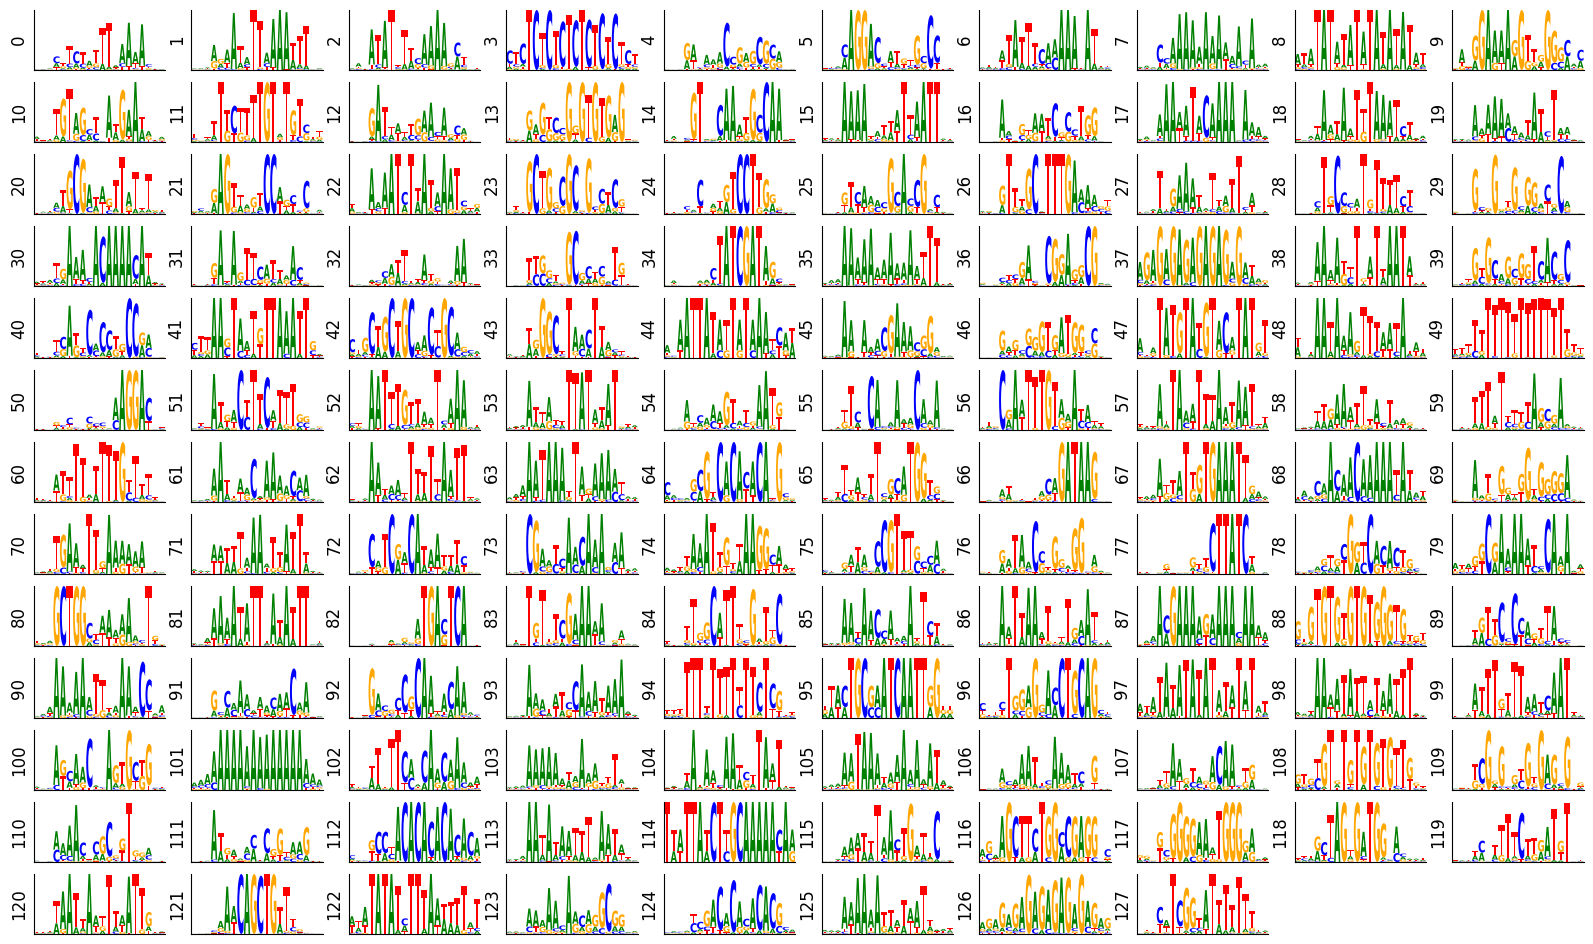

In [12]:
# interpret model
tuner.interpret_model(layer=3)

if(config['conv1_channel_weight'] == "softconv"):
        layer = 5
elif(config['conv1_channel_weight'] == "se"):
    layer = 8
else:
    layer = None
    print("Finished interpreting!")
    
tuner.interpret_model(layer=layer)    

In [14]:
save_path

'/home/chandana/projects/hominid_pipeline/experiments/model_variations/tune_hominid_8f34a_00058_58_conv1_activation=relu,conv1_attention_pool_size=30,conv1_batchnorm=False,conv1_channel_weight=softconv_2023-05-17_22-09-59/exponential/variations/variation_1'

Loading model and dataset!
Building model...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 249, 4)]     0           []                               
                                                                                                  
 pairwise_conv1d (PairwiseConv1  (None, 249, 128)    234368      ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 249, 128)     512         ['pairwise_conv1d[0][0]']        
                                                                                                  
 conv1_activation (Activation)  (None, 249, 128)     0           ['conv1_bn[0][0]']           

  0%|                                                                                                                                         | 0/643 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|▏                                                                                                                                | 1/643 [00:00<01:51,  5.75it/s]

2/2 [==============================] - 0s 3ms/step


  0%|▌                                                                                                                                | 3/643 [00:00<00:59, 10.76it/s]

2/2 [==============================] - 0s 3ms/step


  1%|█                                                                                                                                | 5/643 [00:00<00:49, 12.77it/s]

2/2 [==============================] - 0s 2ms/step


  1%|█▍                                                                                                                               | 7/643 [00:00<00:45, 14.08it/s]

2/2 [==============================] - 0s 3ms/step


  1%|█▊                                                                                                                               | 9/643 [00:00<00:43, 14.42it/s]

2/2 [==============================] - 0s 3ms/step


  2%|██▏                                                                                                                             | 11/643 [00:00<00:42, 14.96it/s]

2/2 [==============================] - 0s 3ms/step


  2%|██▌                                                                                                                             | 13/643 [00:00<00:40, 15.39it/s]

2/2 [==============================] - 0s 3ms/step


  2%|██▉                                                                                                                             | 15/643 [00:01<00:40, 15.45it/s]

2/2 [==============================] - 0s 3ms/step


  3%|███▍                                                                                                                            | 17/643 [00:01<00:40, 15.37it/s]

2/2 [==============================] - 0s 3ms/step


  3%|███▊                                                                                                                            | 19/643 [00:01<00:40, 15.54it/s]

2/2 [==============================] - 0s 3ms/step


  3%|████▏                                                                                                                           | 21/643 [00:01<00:39, 15.72it/s]

2/2 [==============================] - 0s 3ms/step


  4%|████▌                                                                                                                           | 23/643 [00:01<00:39, 15.68it/s]

2/2 [==============================] - 0s 3ms/step


  4%|████▉                                                                                                                           | 25/643 [00:01<00:39, 15.74it/s]

2/2 [==============================] - 0s 3ms/step


  4%|█████▎                                                                                                                          | 27/643 [00:01<00:39, 15.56it/s]

2/2 [==============================] - 0s 3ms/step


  5%|█████▊                                                                                                                          | 29/643 [00:01<00:40, 15.06it/s]

2/2 [==============================] - 0s 3ms/step


  5%|██████▏                                                                                                                         | 31/643 [00:02<00:40, 15.15it/s]

2/2 [==============================] - 0s 3ms/step


  5%|██████▌                                                                                                                         | 33/643 [00:02<00:39, 15.45it/s]

2/2 [==============================] - 0s 2ms/step


  5%|██████▉                                                                                                                         | 35/643 [00:02<00:39, 15.55it/s]

2/2 [==============================] - 0s 3ms/step


  6%|███████▎                                                                                                                        | 37/643 [00:02<00:39, 15.50it/s]

2/2 [==============================] - 0s 2ms/step


  6%|███████▊                                                                                                                        | 39/643 [00:02<00:38, 15.74it/s]

2/2 [==============================] - 0s 3ms/step


  6%|████████▏                                                                                                                       | 41/643 [00:02<00:37, 15.99it/s]

2/2 [==============================] - 0s 3ms/step


  7%|████████▌                                                                                                                       | 43/643 [00:02<00:37, 16.13it/s]

2/2 [==============================] - 0s 3ms/step


  7%|████████▉                                                                                                                       | 45/643 [00:02<00:36, 16.18it/s]

2/2 [==============================] - 0s 3ms/step


  7%|█████████▎                                                                                                                      | 47/643 [00:03<00:37, 15.85it/s]

2/2 [==============================] - 0s 3ms/step


  8%|█████████▊                                                                                                                      | 49/643 [00:03<00:37, 15.94it/s]

2/2 [==============================] - 0s 2ms/step


  8%|██████████▏                                                                                                                     | 51/643 [00:03<00:37, 15.59it/s]

2/2 [==============================] - 0s 3ms/step


  8%|██████████▌                                                                                                                     | 53/643 [00:03<00:37, 15.84it/s]

2/2 [==============================] - 0s 2ms/step


  9%|██████████▉                                                                                                                     | 55/643 [00:03<00:36, 16.11it/s]

2/2 [==============================] - 0s 3ms/step


  9%|███████████▎                                                                                                                    | 57/643 [00:03<00:36, 15.91it/s]

2/2 [==============================] - 0s 3ms/step


  9%|███████████▋                                                                                                                    | 59/643 [00:03<00:36, 16.13it/s]

2/2 [==============================] - 0s 2ms/step


  9%|████████████▏                                                                                                                   | 61/643 [00:03<00:35, 16.24it/s]

2/2 [==============================] - 0s 3ms/step


 10%|████████████▌                                                                                                                   | 63/643 [00:04<00:35, 16.33it/s]

2/2 [==============================] - 0s 2ms/step


 10%|████████████▉                                                                                                                   | 65/643 [00:04<00:35, 16.41it/s]

2/2 [==============================] - 0s 3ms/step


 10%|█████████████▎                                                                                                                  | 67/643 [00:04<00:35, 16.18it/s]

2/2 [==============================] - 0s 2ms/step


 11%|█████████████▋                                                                                                                  | 69/643 [00:04<00:35, 16.36it/s]

2/2 [==============================] - 0s 2ms/step


 11%|██████████████▏                                                                                                                 | 71/643 [00:04<00:34, 16.39it/s]

2/2 [==============================] - 0s 3ms/step


 11%|██████████████▌                                                                                                                 | 73/643 [00:04<00:34, 16.50it/s]

2/2 [==============================] - 0s 2ms/step


 12%|██████████████▉                                                                                                                 | 75/643 [00:04<00:33, 16.71it/s]

2/2 [==============================] - 0s 3ms/step


 12%|███████████████▎                                                                                                                | 77/643 [00:04<00:34, 16.28it/s]

2/2 [==============================] - 0s 2ms/step


 12%|███████████████▋                                                                                                                | 79/643 [00:05<00:34, 16.31it/s]

2/2 [==============================] - 0s 2ms/step


 13%|████████████████                                                                                                                | 81/643 [00:05<00:33, 16.63it/s]

2/2 [==============================] - 0s 2ms/step


 13%|████████████████▌                                                                                                               | 83/643 [00:05<00:33, 16.67it/s]

2/2 [==============================] - 0s 3ms/step


 13%|████████████████▉                                                                                                               | 85/643 [00:05<00:33, 16.87it/s]

2/2 [==============================] - 0s 2ms/step


 14%|█████████████████▎                                                                                                              | 87/643 [00:05<00:33, 16.55it/s]

2/2 [==============================] - 0s 2ms/step


 14%|█████████████████▋                                                                                                              | 89/643 [00:05<00:33, 16.67it/s]

2/2 [==============================] - 0s 3ms/step


 14%|██████████████████                                                                                                              | 91/643 [00:05<00:32, 16.79it/s]

2/2 [==============================] - 0s 2ms/step


 14%|██████████████████▌                                                                                                             | 93/643 [00:05<00:32, 16.89it/s]

2/2 [==============================] - 0s 2ms/step


 15%|██████████████████▉                                                                                                             | 95/643 [00:06<00:32, 16.92it/s]

2/2 [==============================] - 0s 3ms/step


 15%|███████████████████▎                                                                                                            | 97/643 [00:06<00:33, 16.48it/s]

2/2 [==============================] - 0s 3ms/step


 15%|███████████████████▋                                                                                                            | 99/643 [00:06<00:32, 16.81it/s]

2/2 [==============================] - 0s 2ms/step


 16%|███████████████████▉                                                                                                           | 101/643 [00:06<00:31, 17.09it/s]

2/2 [==============================] - 0s 2ms/step


 16%|████████████████████▎                                                                                                          | 103/643 [00:06<00:31, 17.27it/s]

2/2 [==============================] - 0s 2ms/step


 16%|████████████████████▋                                                                                                          | 105/643 [00:06<00:32, 16.34it/s]

2/2 [==============================] - 0s 2ms/step


 17%|█████████████████████▏                                                                                                         | 107/643 [00:06<00:32, 16.38it/s]

2/2 [==============================] - 0s 2ms/step


 17%|█████████████████████▌                                                                                                         | 109/643 [00:06<00:31, 16.71it/s]

2/2 [==============================] - 0s 3ms/step


 17%|█████████████████████▉                                                                                                         | 111/643 [00:06<00:31, 16.74it/s]

2/2 [==============================] - 0s 2ms/step


 18%|██████████████████████▎                                                                                                        | 113/643 [00:07<00:31, 16.69it/s]

2/2 [==============================] - 0s 2ms/step


 18%|██████████████████████▋                                                                                                        | 115/643 [00:07<00:32, 16.23it/s]

2/2 [==============================] - 0s 3ms/step


 18%|███████████████████████                                                                                                        | 117/643 [00:07<00:32, 16.10it/s]

2/2 [==============================] - 0s 3ms/step


 19%|███████████████████████▌                                                                                                       | 119/643 [00:07<00:31, 16.40it/s]

2/2 [==============================] - 0s 3ms/step


 19%|███████████████████████▉                                                                                                       | 121/643 [00:07<00:31, 16.56it/s]

2/2 [==============================] - 0s 2ms/step


 19%|████████████████████████▎                                                                                                      | 123/643 [00:07<00:30, 16.82it/s]

2/2 [==============================] - 0s 2ms/step


 19%|████████████████████████▋                                                                                                      | 125/643 [00:07<00:30, 17.05it/s]

2/2 [==============================] - 0s 3ms/step


 20%|█████████████████████████                                                                                                      | 127/643 [00:07<00:30, 16.71it/s]

2/2 [==============================] - 0s 3ms/step


 20%|█████████████████████████▍                                                                                                     | 129/643 [00:08<00:30, 16.80it/s]

2/2 [==============================] - 0s 2ms/step


 20%|█████████████████████████▊                                                                                                     | 131/643 [00:08<00:29, 17.07it/s]

2/2 [==============================] - 0s 2ms/step


 21%|██████████████████████████▎                                                                                                    | 133/643 [00:08<00:29, 17.20it/s]

2/2 [==============================] - 0s 2ms/step


 21%|██████████████████████████▋                                                                                                    | 135/643 [00:08<00:29, 17.02it/s]

2/2 [==============================] - 0s 3ms/step


 21%|███████████████████████████                                                                                                    | 137/643 [00:08<00:29, 16.88it/s]

2/2 [==============================] - 0s 4ms/step


 22%|███████████████████████████▍                                                                                                   | 139/643 [00:08<00:29, 16.93it/s]

2/2 [==============================] - 0s 2ms/step


 22%|███████████████████████████▊                                                                                                   | 141/643 [00:08<00:35, 14.20it/s]

2/2 [==============================] - 0s 2ms/step


 22%|████████████████████████████▏                                                                                                  | 143/643 [00:08<00:33, 15.06it/s]

2/2 [==============================] - 0s 2ms/step


 23%|████████████████████████████▋                                                                                                  | 145/643 [00:09<00:31, 15.74it/s]

2/2 [==============================] - 0s 3ms/step


 23%|█████████████████████████████                                                                                                  | 147/643 [00:09<00:31, 15.93it/s]

2/2 [==============================] - 0s 2ms/step


 23%|█████████████████████████████▍                                                                                                 | 149/643 [00:09<00:30, 16.08it/s]

2/2 [==============================] - 0s 3ms/step


 23%|█████████████████████████████▊                                                                                                 | 151/643 [00:09<00:30, 16.32it/s]

2/2 [==============================] - 0s 3ms/step


 24%|██████████████████████████████▏                                                                                                | 153/643 [00:09<00:32, 14.89it/s]

2/2 [==============================] - 0s 2ms/step


 24%|██████████████████████████████▌                                                                                                | 155/643 [00:09<00:33, 14.35it/s]

2/2 [==============================] - 0s 3ms/step


 24%|███████████████████████████████                                                                                                | 157/643 [00:09<00:32, 14.82it/s]

2/2 [==============================] - 0s 2ms/step


 25%|███████████████████████████████▍                                                                                               | 159/643 [00:09<00:31, 15.57it/s]

2/2 [==============================] - 0s 2ms/step


 25%|███████████████████████████████▊                                                                                               | 161/643 [00:10<00:29, 16.14it/s]

2/2 [==============================] - 0s 3ms/step


 25%|████████████████████████████████▏                                                                                              | 163/643 [00:10<00:29, 16.52it/s]

2/2 [==============================] - 0s 2ms/step


 26%|████████████████████████████████▌                                                                                              | 165/643 [00:10<00:28, 16.85it/s]

2/2 [==============================] - 0s 3ms/step


 26%|████████████████████████████████▉                                                                                              | 167/643 [00:10<00:28, 16.58it/s]

2/2 [==============================] - 0s 2ms/step


 26%|█████████████████████████████████▍                                                                                             | 169/643 [00:10<00:28, 16.87it/s]

2/2 [==============================] - 0s 3ms/step


 27%|█████████████████████████████████▊                                                                                             | 171/643 [00:10<00:28, 16.34it/s]

2/2 [==============================] - 0s 2ms/step


 27%|██████████████████████████████████▏                                                                                            | 173/643 [00:10<00:28, 16.64it/s]

2/2 [==============================] - 0s 2ms/step


 27%|██████████████████████████████████▌                                                                                            | 175/643 [00:10<00:27, 16.96it/s]

2/2 [==============================] - 0s 3ms/step


 28%|██████████████████████████████████▉                                                                                            | 177/643 [00:11<00:28, 16.61it/s]

2/2 [==============================] - 0s 3ms/step


 28%|███████████████████████████████████▎                                                                                           | 179/643 [00:11<00:27, 16.72it/s]

2/2 [==============================] - 0s 3ms/step


 28%|███████████████████████████████████▋                                                                                           | 181/643 [00:11<00:27, 16.93it/s]

2/2 [==============================] - 0s 3ms/step


 28%|████████████████████████████████████▏                                                                                          | 183/643 [00:11<00:28, 15.98it/s]

2/2 [==============================] - 0s 2ms/step


 29%|████████████████████████████████████▌                                                                                          | 185/643 [00:11<00:28, 16.07it/s]

2/2 [==============================] - 0s 2ms/step


 29%|████████████████████████████████████▉                                                                                          | 187/643 [00:11<00:28, 16.14it/s]

2/2 [==============================] - 0s 2ms/step


 29%|█████████████████████████████████████▎                                                                                         | 189/643 [00:11<00:27, 16.47it/s]

2/2 [==============================] - 0s 3ms/step


 30%|█████████████████████████████████████▋                                                                                         | 191/643 [00:11<00:26, 16.85it/s]

2/2 [==============================] - 0s 2ms/step


 30%|██████████████████████████████████████                                                                                         | 193/643 [00:12<00:26, 17.13it/s]

2/2 [==============================] - 0s 3ms/step


 30%|██████████████████████████████████████▌                                                                                        | 195/643 [00:12<00:26, 16.84it/s]

2/2 [==============================] - 0s 3ms/step


 31%|██████████████████████████████████████▉                                                                                        | 197/643 [00:12<00:27, 16.21it/s]

2/2 [==============================] - 0s 3ms/step


 31%|███████████████████████████████████████▎                                                                                       | 199/643 [00:12<00:26, 16.53it/s]

2/2 [==============================] - 0s 3ms/step


 31%|███████████████████████████████████████▋                                                                                       | 201/643 [00:12<00:26, 16.78it/s]

2/2 [==============================] - 0s 3ms/step


 32%|████████████████████████████████████████                                                                                       | 203/643 [00:12<00:25, 17.10it/s]

2/2 [==============================] - 0s 3ms/step


 32%|████████████████████████████████████████▍                                                                                      | 205/643 [00:12<00:26, 16.79it/s]

2/2 [==============================] - 0s 3ms/step


 32%|████████████████████████████████████████▉                                                                                      | 207/643 [00:12<00:25, 16.90it/s]

2/2 [==============================] - 0s 3ms/step


 33%|█████████████████████████████████████████▎                                                                                     | 209/643 [00:12<00:25, 17.03it/s]

2/2 [==============================] - 0s 3ms/step


 33%|█████████████████████████████████████████▋                                                                                     | 211/643 [00:13<00:25, 17.04it/s]

2/2 [==============================] - 0s 3ms/step


 33%|██████████████████████████████████████████                                                                                     | 213/643 [00:13<00:25, 17.14it/s]

2/2 [==============================] - 0s 3ms/step


 33%|██████████████████████████████████████████▍                                                                                    | 215/643 [00:13<00:28, 15.05it/s]

2/2 [==============================] - 0s 3ms/step


 34%|██████████████████████████████████████████▊                                                                                    | 217/643 [00:13<00:27, 15.58it/s]

2/2 [==============================] - 0s 2ms/step


 34%|███████████████████████████████████████████▎                                                                                   | 219/643 [00:13<00:29, 14.24it/s]

2/2 [==============================] - 0s 2ms/step


 34%|███████████████████████████████████████████▋                                                                                   | 221/643 [00:13<00:33, 12.78it/s]

2/2 [==============================] - 0s 3ms/step


 35%|████████████████████████████████████████████                                                                                   | 223/643 [00:13<00:30, 13.85it/s]

2/2 [==============================] - 0s 3ms/step


 35%|████████████████████████████████████████████▍                                                                                  | 225/643 [00:14<00:28, 14.55it/s]

2/2 [==============================] - 0s 2ms/step


 35%|████████████████████████████████████████████▊                                                                                  | 227/643 [00:14<00:27, 15.26it/s]

2/2 [==============================] - 0s 3ms/step


 36%|█████████████████████████████████████████████▏                                                                                 | 229/643 [00:14<00:29, 14.00it/s]

2/2 [==============================] - 0s 2ms/step


 36%|█████████████████████████████████████████████▋                                                                                 | 231/643 [00:14<00:27, 14.82it/s]

2/2 [==============================] - 0s 2ms/step


 36%|██████████████████████████████████████████████                                                                                 | 233/643 [00:14<00:26, 15.50it/s]

2/2 [==============================] - 0s 2ms/step


 37%|██████████████████████████████████████████████▍                                                                                | 235/643 [00:14<00:25, 15.70it/s]

2/2 [==============================] - 0s 2ms/step


 37%|██████████████████████████████████████████████▊                                                                                | 237/643 [00:14<00:25, 16.12it/s]

2/2 [==============================] - 0s 2ms/step


 37%|███████████████████████████████████████████████▏                                                                               | 239/643 [00:14<00:24, 16.37it/s]

2/2 [==============================] - 0s 3ms/step


 37%|███████████████████████████████████████████████▌                                                                               | 241/643 [00:15<00:23, 16.78it/s]

2/2 [==============================] - 0s 2ms/step


 38%|███████████████████████████████████████████████▉                                                                               | 243/643 [00:15<00:23, 17.09it/s]

2/2 [==============================] - 0s 2ms/step


 38%|████████████████████████████████████████████████▍                                                                              | 245/643 [00:15<00:23, 16.99it/s]

2/2 [==============================] - 0s 2ms/step


 38%|████████████████████████████████████████████████▊                                                                              | 247/643 [00:15<00:23, 17.16it/s]

2/2 [==============================] - 0s 3ms/step


 39%|█████████████████████████████████████████████████▏                                                                             | 249/643 [00:15<00:22, 17.19it/s]

2/2 [==============================] - 0s 3ms/step


 39%|█████████████████████████████████████████████████▌                                                                             | 251/643 [00:15<00:22, 17.27it/s]

2/2 [==============================] - 0s 2ms/step


 39%|█████████████████████████████████████████████████▉                                                                             | 253/643 [00:15<00:22, 17.44it/s]

2/2 [==============================] - 0s 2ms/step


 40%|██████████████████████████████████████████████████▎                                                                            | 255/643 [00:15<00:22, 17.16it/s]

2/2 [==============================] - 0s 2ms/step


 40%|██████████████████████████████████████████████████▊                                                                            | 257/643 [00:15<00:22, 17.18it/s]

2/2 [==============================] - 0s 3ms/step


 40%|███████████████████████████████████████████████████▏                                                                           | 259/643 [00:16<00:22, 17.33it/s]

2/2 [==============================] - 0s 2ms/step


 41%|███████████████████████████████████████████████████▌                                                                           | 261/643 [00:16<00:21, 17.39it/s]

2/2 [==============================] - 0s 2ms/step


 41%|███████████████████████████████████████████████████▉                                                                           | 263/643 [00:16<00:21, 17.53it/s]

2/2 [==============================] - 0s 2ms/step


 41%|████████████████████████████████████████████████████▎                                                                          | 265/643 [00:16<00:21, 17.19it/s]

2/2 [==============================] - 0s 2ms/step


 42%|████████████████████████████████████████████████████▋                                                                          | 267/643 [00:16<00:21, 17.40it/s]

2/2 [==============================] - 0s 3ms/step


 42%|█████████████████████████████████████████████████████▏                                                                         | 269/643 [00:16<00:21, 17.54it/s]

2/2 [==============================] - 0s 3ms/step


 42%|█████████████████████████████████████████████████████▌                                                                         | 271/643 [00:16<00:21, 17.45it/s]

2/2 [==============================] - 0s 3ms/step


 42%|█████████████████████████████████████████████████████▉                                                                         | 273/643 [00:16<00:20, 17.63it/s]

2/2 [==============================] - 0s 2ms/step


 43%|██████████████████████████████████████████████████████▎                                                                        | 275/643 [00:17<00:21, 17.22it/s]

2/2 [==============================] - 0s 3ms/step


 43%|██████████████████████████████████████████████████████▋                                                                        | 277/643 [00:17<00:21, 17.31it/s]

2/2 [==============================] - 0s 2ms/step


 43%|███████████████████████████████████████████████████████                                                                        | 279/643 [00:17<00:20, 17.36it/s]

2/2 [==============================] - 0s 2ms/step


 44%|███████████████████████████████████████████████████████▌                                                                       | 281/643 [00:17<00:20, 17.47it/s]

2/2 [==============================] - 0s 3ms/step


 44%|███████████████████████████████████████████████████████▉                                                                       | 283/643 [00:17<00:20, 17.60it/s]

2/2 [==============================] - 0s 3ms/step


 44%|████████████████████████████████████████████████████████▎                                                                      | 285/643 [00:17<00:20, 17.23it/s]

2/2 [==============================] - 0s 2ms/step


 45%|████████████████████████████████████████████████████████▋                                                                      | 287/643 [00:17<00:20, 17.31it/s]

2/2 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████████████████                                                                      | 289/643 [00:17<00:20, 17.24it/s]

2/2 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████████████████▍                                                                     | 291/643 [00:17<00:20, 17.32it/s]

2/2 [==============================] - 0s 3ms/step


 46%|█████████████████████████████████████████████████████████▊                                                                     | 293/643 [00:18<00:20, 17.34it/s]

2/2 [==============================] - 0s 3ms/step


 46%|██████████████████████████████████████████████████████████▎                                                                    | 295/643 [00:18<00:20, 17.13it/s]

2/2 [==============================] - 0s 2ms/step


 46%|██████████████████████████████████████████████████████████▋                                                                    | 297/643 [00:18<00:20, 17.27it/s]

2/2 [==============================] - 0s 2ms/step


 47%|███████████████████████████████████████████████████████████                                                                    | 299/643 [00:18<00:19, 17.45it/s]

2/2 [==============================] - 0s 2ms/step


 47%|███████████████████████████████████████████████████████████▍                                                                   | 301/643 [00:18<00:19, 17.55it/s]

2/2 [==============================] - 0s 2ms/step


 47%|███████████████████████████████████████████████████████████▊                                                                   | 303/643 [00:18<00:19, 17.52it/s]

2/2 [==============================] - 0s 2ms/step


 47%|████████████████████████████████████████████████████████████▏                                                                  | 305/643 [00:18<00:19, 17.08it/s]

2/2 [==============================] - 0s 3ms/step


 48%|████████████████████████████████████████████████████████████▋                                                                  | 307/643 [00:18<00:19, 17.20it/s]

2/2 [==============================] - 0s 2ms/step


 48%|█████████████████████████████████████████████████████████████                                                                  | 309/643 [00:18<00:19, 17.21it/s]

2/2 [==============================] - 0s 3ms/step


 48%|█████████████████████████████████████████████████████████████▍                                                                 | 311/643 [00:19<00:19, 17.42it/s]

2/2 [==============================] - 0s 3ms/step


 49%|█████████████████████████████████████████████████████████████▊                                                                 | 313/643 [00:19<00:18, 17.37it/s]

2/2 [==============================] - 0s 2ms/step


 49%|██████████████████████████████████████████████████████████████▏                                                                | 315/643 [00:19<00:19, 16.78it/s]

2/2 [==============================] - 0s 3ms/step


 49%|██████████████████████████████████████████████████████████████▌                                                                | 317/643 [00:19<00:19, 16.96it/s]

2/2 [==============================] - 0s 2ms/step


 50%|███████████████████████████████████████████████████████████████                                                                | 319/643 [00:19<00:18, 17.21it/s]

2/2 [==============================] - 0s 2ms/step


 50%|███████████████████████████████████████████████████████████████▍                                                               | 321/643 [00:19<00:18, 17.38it/s]

2/2 [==============================] - 0s 2ms/step


 50%|███████████████████████████████████████████████████████████████▊                                                               | 323/643 [00:19<00:18, 17.38it/s]

2/2 [==============================] - 0s 3ms/step


 51%|████████████████████████████████████████████████████████████████▏                                                              | 325/643 [00:19<00:18, 17.04it/s]

2/2 [==============================] - 0s 3ms/step


 51%|████████████████████████████████████████████████████████████████▌                                                              | 327/643 [00:20<00:18, 17.09it/s]

2/2 [==============================] - 0s 2ms/step


 51%|████████████████████████████████████████████████████████████████▉                                                              | 329/643 [00:20<00:18, 17.30it/s]

2/2 [==============================] - 0s 3ms/step


 51%|█████████████████████████████████████████████████████████████████▍                                                             | 331/643 [00:20<00:17, 17.34it/s]

2/2 [==============================] - 0s 2ms/step


 52%|█████████████████████████████████████████████████████████████████▊                                                             | 333/643 [00:20<00:17, 17.54it/s]

2/2 [==============================] - 0s 2ms/step


 52%|██████████████████████████████████████████████████████████████████▏                                                            | 335/643 [00:20<00:17, 17.29it/s]

2/2 [==============================] - 0s 2ms/step


 52%|██████████████████████████████████████████████████████████████████▌                                                            | 337/643 [00:20<00:17, 17.45it/s]

2/2 [==============================] - 0s 2ms/step


 53%|██████████████████████████████████████████████████████████████████▉                                                            | 339/643 [00:20<00:17, 17.62it/s]

2/2 [==============================] - 0s 3ms/step


 53%|███████████████████████████████████████████████████████████████████▎                                                           | 341/643 [00:20<00:17, 17.58it/s]

2/2 [==============================] - 0s 3ms/step


 53%|███████████████████████████████████████████████████████████████████▋                                                           | 343/643 [00:20<00:16, 17.73it/s]

2/2 [==============================] - 0s 2ms/step


 54%|████████████████████████████████████████████████████████████████████▏                                                          | 345/643 [00:21<00:17, 17.10it/s]

2/2 [==============================] - 0s 3ms/step


 54%|████████████████████████████████████████████████████████████████████▌                                                          | 347/643 [00:21<00:17, 17.21it/s]

2/2 [==============================] - 0s 3ms/step


 54%|████████████████████████████████████████████████████████████████████▉                                                          | 349/643 [00:21<00:16, 17.36it/s]

2/2 [==============================] - 0s 2ms/step


 55%|█████████████████████████████████████████████████████████████████████▎                                                         | 351/643 [00:21<00:16, 17.55it/s]

2/2 [==============================] - 0s 3ms/step


 55%|█████████████████████████████████████████████████████████████████████▋                                                         | 353/643 [00:21<00:16, 17.47it/s]

2/2 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████████████████████                                                         | 355/643 [00:21<00:16, 17.25it/s]

2/2 [==============================] - 0s 2ms/step


 56%|██████████████████████████████████████████████████████████████████████▌                                                        | 357/643 [00:21<00:16, 17.30it/s]

2/2 [==============================] - 0s 2ms/step


 56%|██████████████████████████████████████████████████████████████████████▉                                                        | 359/643 [00:21<00:16, 17.34it/s]

2/2 [==============================] - 0s 2ms/step


 56%|███████████████████████████████████████████████████████████████████████▎                                                       | 361/643 [00:21<00:16, 17.54it/s]

2/2 [==============================] - 0s 2ms/step


 56%|███████████████████████████████████████████████████████████████████████▋                                                       | 363/643 [00:22<00:15, 17.65it/s]

2/2 [==============================] - 0s 3ms/step


 57%|████████████████████████████████████████████████████████████████████████                                                       | 365/643 [00:22<00:16, 17.30it/s]

2/2 [==============================] - 0s 3ms/step


 57%|████████████████████████████████████████████████████████████████████████▍                                                      | 367/643 [00:22<00:15, 17.30it/s]

2/2 [==============================] - 0s 2ms/step


 57%|████████████████████████████████████████████████████████████████████████▉                                                      | 369/643 [00:22<00:15, 17.53it/s]

2/2 [==============================] - 0s 2ms/step


 58%|█████████████████████████████████████████████████████████████████████████▎                                                     | 371/643 [00:22<00:15, 17.56it/s]

2/2 [==============================] - 0s 2ms/step


 58%|█████████████████████████████████████████████████████████████████████████▋                                                     | 373/643 [00:22<00:15, 17.70it/s]

2/2 [==============================] - 0s 2ms/step


 58%|██████████████████████████████████████████████████████████████████████████                                                     | 375/643 [00:22<00:15, 17.40it/s]

2/2 [==============================] - 0s 2ms/step


 59%|██████████████████████████████████████████████████████████████████████████▍                                                    | 377/643 [00:22<00:15, 17.47it/s]

2/2 [==============================] - 0s 2ms/step


 59%|██████████████████████████████████████████████████████████████████████████▊                                                    | 379/643 [00:23<00:15, 17.18it/s]

2/2 [==============================] - 0s 3ms/step


 59%|███████████████████████████████████████████████████████████████████████████▎                                                   | 381/643 [00:23<00:15, 17.39it/s]

2/2 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████████████████████▋                                                   | 383/643 [00:23<00:15, 17.32it/s]

2/2 [==============================] - 0s 3ms/step


 60%|████████████████████████████████████████████████████████████████████████████                                                   | 385/643 [00:23<00:15, 16.91it/s]

2/2 [==============================] - 0s 3ms/step


 60%|████████████████████████████████████████████████████████████████████████████▍                                                  | 387/643 [00:23<00:15, 17.06it/s]

2/2 [==============================] - 0s 2ms/step


 60%|████████████████████████████████████████████████████████████████████████████▊                                                  | 389/643 [00:23<00:14, 17.17it/s]

2/2 [==============================] - 0s 3ms/step


 61%|█████████████████████████████████████████████████████████████████████████████▏                                                 | 391/643 [00:23<00:14, 17.09it/s]

2/2 [==============================] - 0s 2ms/step


 61%|█████████████████████████████████████████████████████████████████████████████▌                                                 | 393/643 [00:23<00:14, 17.33it/s]

2/2 [==============================] - 0s 3ms/step


 61%|██████████████████████████████████████████████████████████████████████████████                                                 | 395/643 [00:23<00:14, 17.12it/s]

2/2 [==============================] - 0s 2ms/step


 62%|██████████████████████████████████████████████████████████████████████████████▍                                                | 397/643 [00:24<00:14, 17.21it/s]

2/2 [==============================] - 0s 2ms/step


 62%|██████████████████████████████████████████████████████████████████████████████▊                                                | 399/643 [00:24<00:14, 17.41it/s]

2/2 [==============================] - 0s 2ms/step


 62%|███████████████████████████████████████████████████████████████████████████████▏                                               | 401/643 [00:24<00:13, 17.49it/s]

2/2 [==============================] - 0s 3ms/step


 63%|███████████████████████████████████████████████████████████████████████████████▌                                               | 403/643 [00:24<00:13, 17.29it/s]

2/2 [==============================] - 0s 2ms/step


 63%|███████████████████████████████████████████████████████████████████████████████▉                                               | 405/643 [00:24<00:13, 17.09it/s]

2/2 [==============================] - 0s 3ms/step


 63%|████████████████████████████████████████████████████████████████████████████████▍                                              | 407/643 [00:24<00:13, 17.27it/s]

2/2 [==============================] - 0s 3ms/step


 64%|████████████████████████████████████████████████████████████████████████████████▊                                              | 409/643 [00:24<00:13, 17.34it/s]

2/2 [==============================] - 0s 2ms/step


 64%|█████████████████████████████████████████████████████████████████████████████████▏                                             | 411/643 [00:24<00:13, 17.45it/s]

2/2 [==============================] - 0s 3ms/step


 64%|█████████████████████████████████████████████████████████████████████████████████▌                                             | 413/643 [00:24<00:13, 17.58it/s]

2/2 [==============================] - 0s 2ms/step


 65%|█████████████████████████████████████████████████████████████████████████████████▉                                             | 415/643 [00:25<00:13, 17.05it/s]

2/2 [==============================] - 0s 2ms/step


 65%|██████████████████████████████████████████████████████████████████████████████████▎                                            | 417/643 [00:25<00:13, 17.01it/s]

2/2 [==============================] - 0s 2ms/step


 65%|██████████████████████████████████████████████████████████████████████████████████▊                                            | 419/643 [00:25<00:13, 17.15it/s]

2/2 [==============================] - 0s 3ms/step


 65%|███████████████████████████████████████████████████████████████████████████████████▏                                           | 421/643 [00:25<00:12, 17.21it/s]

2/2 [==============================] - 0s 2ms/step


 66%|███████████████████████████████████████████████████████████████████████████████████▌                                           | 423/643 [00:25<00:12, 17.45it/s]

2/2 [==============================] - 0s 3ms/step


 66%|███████████████████████████████████████████████████████████████████████████████████▉                                           | 425/643 [00:25<00:12, 17.15it/s]

2/2 [==============================] - 0s 2ms/step


 66%|████████████████████████████████████████████████████████████████████████████████████▎                                          | 427/643 [00:25<00:12, 17.28it/s]

2/2 [==============================] - 0s 2ms/step


 67%|████████████████████████████████████████████████████████████████████████████████████▋                                          | 429/643 [00:25<00:12, 17.46it/s]

2/2 [==============================] - 0s 3ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████▏                                         | 431/643 [00:26<00:12, 17.42it/s]

2/2 [==============================] - 0s 2ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████▌                                         | 433/643 [00:26<00:12, 17.48it/s]

2/2 [==============================] - 0s 2ms/step


 68%|█████████████████████████████████████████████████████████████████████████████████████▉                                         | 435/643 [00:26<00:12, 17.12it/s]

2/2 [==============================] - 0s 2ms/step


 68%|██████████████████████████████████████████████████████████████████████████████████████▎                                        | 437/643 [00:26<00:11, 17.24it/s]

2/2 [==============================] - 0s 2ms/step


 68%|██████████████████████████████████████████████████████████████████████████████████████▋                                        | 439/643 [00:26<00:11, 17.23it/s]

2/2 [==============================] - 0s 2ms/step


 69%|███████████████████████████████████████████████████████████████████████████████████████                                        | 441/643 [00:26<00:11, 17.48it/s]

2/2 [==============================] - 0s 3ms/step


 69%|███████████████████████████████████████████████████████████████████████████████████████▍                                       | 443/643 [00:26<00:11, 17.54it/s]

2/2 [==============================] - 0s 2ms/step


 69%|███████████████████████████████████████████████████████████████████████████████████████▉                                       | 445/643 [00:26<00:11, 17.09it/s]

2/2 [==============================] - 0s 3ms/step


 70%|████████████████████████████████████████████████████████████████████████████████████████▎                                      | 447/643 [00:26<00:11, 17.26it/s]

2/2 [==============================] - 0s 3ms/step


 70%|████████████████████████████████████████████████████████████████████████████████████████▋                                      | 449/643 [00:27<00:11, 17.17it/s]

2/2 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 451/643 [00:27<00:11, 17.24it/s]

2/2 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                     | 453/643 [00:27<00:10, 17.40it/s]

2/2 [==============================] - 0s 2ms/step


 71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                     | 455/643 [00:27<00:10, 17.27it/s]

2/2 [==============================] - 0s 3ms/step


 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                    | 457/643 [00:27<00:10, 17.40it/s]

2/2 [==============================] - 0s 2ms/step


 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                    | 459/643 [00:27<00:10, 17.49it/s]

2/2 [==============================] - 0s 2ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 461/643 [00:27<00:10, 17.67it/s]

2/2 [==============================] - 0s 3ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 463/643 [00:27<00:10, 17.69it/s]

2/2 [==============================] - 0s 2ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                   | 465/643 [00:27<00:10, 17.27it/s]

2/2 [==============================] - 0s 2ms/step


 73%|████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 467/643 [00:28<00:10, 17.30it/s]

2/2 [==============================] - 0s 3ms/step


 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 469/643 [00:28<00:10, 17.16it/s]

2/2 [==============================] - 0s 3ms/step


 73%|█████████████████████████████████████████████████████████████████████████████████████████████                                  | 471/643 [00:28<00:10, 17.16it/s]

2/2 [==============================] - 0s 2ms/step


 74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 473/643 [00:28<00:09, 17.31it/s]

2/2 [==============================] - 0s 2ms/step


 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 475/643 [00:28<00:09, 17.08it/s]

2/2 [==============================] - 0s 3ms/step


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                | 477/643 [00:28<00:09, 17.28it/s]

2/2 [==============================] - 0s 3ms/step


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                | 479/643 [00:28<00:09, 17.42it/s]

2/2 [==============================] - 0s 2ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████                                | 481/643 [00:28<00:09, 17.42it/s]

2/2 [==============================] - 0s 3ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                               | 483/643 [00:29<00:09, 17.11it/s]

2/2 [==============================] - 0s 3ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                               | 485/643 [00:29<00:09, 16.54it/s]

2/2 [==============================] - 0s 2ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 487/643 [00:29<00:09, 16.78it/s]

2/2 [==============================] - 0s 2ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 489/643 [00:29<00:09, 17.05it/s]

2/2 [==============================] - 0s 2ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 491/643 [00:29<00:08, 17.19it/s]

2/2 [==============================] - 0s 2ms/step


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 493/643 [00:29<00:08, 17.39it/s]

2/2 [==============================] - 0s 3ms/step


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 495/643 [00:29<00:08, 17.16it/s]

2/2 [==============================] - 0s 2ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 497/643 [00:29<00:08, 17.22it/s]

2/2 [==============================] - 0s 2ms/step


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 499/643 [00:29<00:08, 17.37it/s]

2/2 [==============================] - 0s 3ms/step


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 501/643 [00:30<00:08, 17.37it/s]

2/2 [==============================] - 0s 2ms/step


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 503/643 [00:30<00:08, 17.34it/s]

2/2 [==============================] - 0s 2ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 505/643 [00:30<00:08, 16.93it/s]

2/2 [==============================] - 0s 2ms/step


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 507/643 [00:30<00:07, 17.01it/s]

2/2 [==============================] - 0s 2ms/step


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 509/643 [00:30<00:07, 17.29it/s]

2/2 [==============================] - 0s 3ms/step


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 511/643 [00:30<00:07, 17.50it/s]

2/2 [==============================] - 0s 3ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 513/643 [00:30<00:07, 17.67it/s]

2/2 [==============================] - 0s 2ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 515/643 [00:30<00:07, 17.23it/s]

2/2 [==============================] - 0s 2ms/step


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                         | 517/643 [00:31<00:07, 17.25it/s]

2/2 [==============================] - 0s 2ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 519/643 [00:31<00:07, 17.47it/s]

2/2 [==============================] - 0s 2ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 521/643 [00:31<00:07, 17.36it/s]

2/2 [==============================] - 0s 2ms/step


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 523/643 [00:31<00:06, 17.59it/s]

2/2 [==============================] - 0s 3ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 525/643 [00:31<00:06, 17.22it/s]

2/2 [==============================] - 0s 2ms/step


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 527/643 [00:31<00:06, 17.26it/s]

2/2 [==============================] - 0s 2ms/step


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 529/643 [00:31<00:06, 17.33it/s]

2/2 [==============================] - 0s 3ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 531/643 [00:31<00:06, 17.17it/s]

2/2 [==============================] - 0s 2ms/step


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 533/643 [00:31<00:06, 17.40it/s]

2/2 [==============================] - 0s 3ms/step


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 535/643 [00:32<00:06, 16.98it/s]

2/2 [==============================] - 0s 2ms/step


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 537/643 [00:32<00:06, 17.23it/s]

2/2 [==============================] - 0s 2ms/step


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 539/643 [00:32<00:05, 17.50it/s]

2/2 [==============================] - 0s 2ms/step


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 541/643 [00:32<00:05, 17.69it/s]

2/2 [==============================] - 0s 2ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 543/643 [00:32<00:05, 17.79it/s]

2/2 [==============================] - 0s 2ms/step


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 545/643 [00:32<00:05, 17.39it/s]

2/2 [==============================] - 0s 3ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 547/643 [00:32<00:05, 17.44it/s]

2/2 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 549/643 [00:32<00:05, 17.49it/s]

2/2 [==============================] - 0s 3ms/step


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 551/643 [00:32<00:05, 17.60it/s]

2/2 [==============================] - 0s 2ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 553/643 [00:33<00:05, 17.55it/s]

2/2 [==============================] - 0s 3ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 555/643 [00:33<00:05, 16.93it/s]

2/2 [==============================] - 0s 2ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 557/643 [00:33<00:05, 16.83it/s]

2/2 [==============================] - 0s 3ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 559/643 [00:33<00:04, 17.02it/s]

2/2 [==============================] - 0s 3ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 561/643 [00:33<00:04, 17.19it/s]

2/2 [==============================] - 0s 2ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 563/643 [00:33<00:04, 17.46it/s]

2/2 [==============================] - 0s 2ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 565/643 [00:33<00:04, 16.69it/s]

2/2 [==============================] - 0s 3ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 567/643 [00:33<00:04, 16.80it/s]

2/2 [==============================] - 0s 2ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 569/643 [00:34<00:04, 16.98it/s]

2/2 [==============================] - 0s 2ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 571/643 [00:34<00:04, 16.82it/s]

2/2 [==============================] - 0s 3ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 573/643 [00:34<00:04, 17.01it/s]

2/2 [==============================] - 0s 3ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 575/643 [00:34<00:04, 16.82it/s]

2/2 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 577/643 [00:34<00:03, 16.62it/s]

2/2 [==============================] - 0s 2ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 579/643 [00:34<00:03, 16.82it/s]

2/2 [==============================] - 0s 2ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 581/643 [00:34<00:03, 16.97it/s]

2/2 [==============================] - 0s 2ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 583/643 [00:34<00:03, 16.76it/s]

2/2 [==============================] - 0s 2ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 585/643 [00:34<00:03, 16.37it/s]

2/2 [==============================] - 0s 2ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 587/643 [00:35<00:03, 16.78it/s]

2/2 [==============================] - 0s 3ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 589/643 [00:35<00:03, 16.51it/s]

2/2 [==============================] - 0s 3ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 591/643 [00:35<00:03, 16.71it/s]

2/2 [==============================] - 0s 3ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 593/643 [00:35<00:03, 16.60it/s]

2/2 [==============================] - 0s 3ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 595/643 [00:35<00:02, 16.21it/s]

2/2 [==============================] - 0s 2ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 597/643 [00:35<00:02, 16.57it/s]

2/2 [==============================] - 0s 3ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 599/643 [00:35<00:02, 16.78it/s]

2/2 [==============================] - 0s 3ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 601/643 [00:35<00:02, 16.90it/s]

2/2 [==============================] - 0s 2ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 603/643 [00:36<00:02, 16.73it/s]

2/2 [==============================] - 0s 3ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 605/643 [00:36<00:02, 16.49it/s]

2/2 [==============================] - 0s 3ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 607/643 [00:36<00:02, 16.68it/s]

2/2 [==============================] - 0s 3ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 609/643 [00:36<00:02, 16.94it/s]

2/2 [==============================] - 0s 2ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 611/643 [00:36<00:01, 17.01it/s]

2/2 [==============================] - 0s 2ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 613/643 [00:36<00:01, 17.32it/s]

2/2 [==============================] - 0s 3ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 615/643 [00:36<00:01, 17.16it/s]

2/2 [==============================] - 0s 3ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 617/643 [00:36<00:01, 17.25it/s]

2/2 [==============================] - 0s 2ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 619/643 [00:36<00:01, 17.39it/s]

2/2 [==============================] - 0s 2ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 621/643 [00:37<00:01, 17.47it/s]

2/2 [==============================] - 0s 2ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 623/643 [00:37<00:01, 17.52it/s]

2/2 [==============================] - 0s 2ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 625/643 [00:37<00:01, 17.27it/s]

2/2 [==============================] - 0s 2ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 627/643 [00:37<00:00, 17.42it/s]

2/2 [==============================] - 0s 3ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 629/643 [00:37<00:00, 17.50it/s]

2/2 [==============================] - 0s 2ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 631/643 [00:37<00:00, 17.61it/s]

2/2 [==============================] - 0s 3ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 633/643 [00:37<00:00, 17.73it/s]

2/2 [==============================] - 0s 2ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 635/643 [00:37<00:00, 17.39it/s]

2/2 [==============================] - 0s 4ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 637/643 [00:38<00:00, 17.21it/s]

2/2 [==============================] - 0s 2ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 639/643 [00:38<00:00, 17.36it/s]

2/2 [==============================] - 0s 2ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 641/643 [00:38<00:00, 17.55it/s]

2/2 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 643/643 [00:38<00:00, 16.76it/s]


Now removing the predictions file!
Calculating filter activations...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:14<00:00,  6.58it/s]


Learned filters : empty filters = 96 : 96
Writing output for RSAT...
Loading filters...
Plotting filters...
Finished interpreting filters!


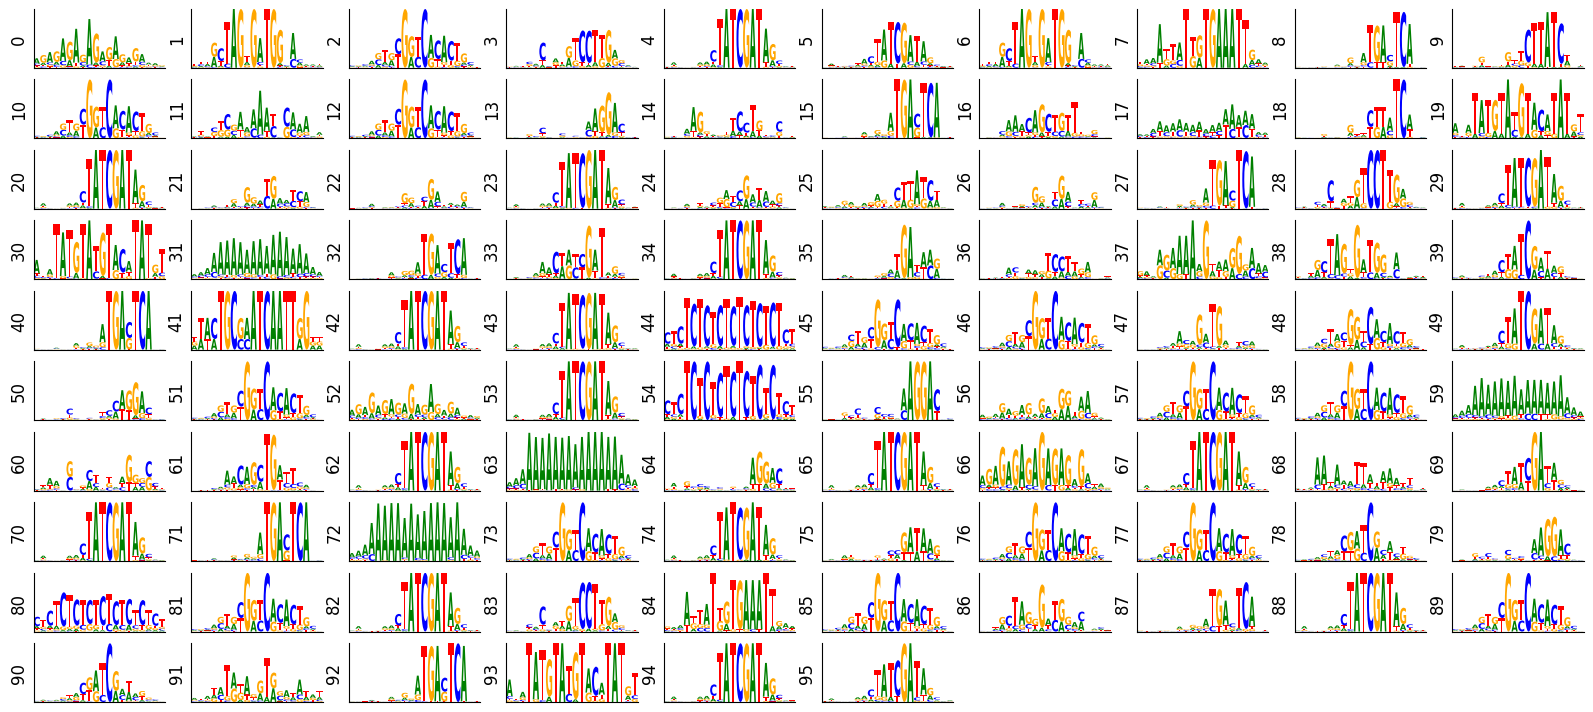

In [13]:
tuner.interpret_model(layer=layer)

In [4]:
df = pd.read_csv("/home/chandana/projects/hominid_pipeline/sweep_explore_variations.csv")

df["trial_log_path"].to_list()

superset = [{'conv1_activation': 'relu',
  'conv1_attention_pool_size': 5,
  'conv1_batchnorm': False,
  'conv1_channel_weight': 'se',
  'conv1_dropout': 0.3,
  'conv1_filters': 256,
  'conv1_kernel_size': 11,
  'conv1_max_pool': 4,
  'conv1_pool_type': 'attention',
  'conv1_type': 'pw',
  'dense_activation': 'relu',
  'dense_batchnorm': True,
  'dense_dropout': [0.3, 0.3],
  'dense_units': [256, 128],
  'mha_d_model': 192,
  'mha_dropout': 0.1,
  'mha_head_type': 'task_specific',
  'mha_heads': 4,
  'mha_layernorm': False,
  'output_activation': 'linear',
  'output_shape': None},
 {'conv1_activation': 'relu',
  'conv1_attention_pool_size': 30,
  'conv1_batchnorm': False,
  'conv1_channel_weight': 'softconv',
  'conv1_dropout': 0.3,
  'conv1_filters': 128,
  'conv1_kernel_size': 19,
  'conv1_max_pool': 4,
  'conv1_pool_type': 'max_pool',
  'conv1_type': 'pw',
  'dense_activation': 'relu',
  'dense_batchnorm': True,
  'dense_dropout': [0.4, 0.4],
  'dense_units': [128, 128],
  'mha_d_model': 96,
  'mha_dropout': 0.1,
  'mha_head_type': 'pool',
  'mha_heads': 8,
  'mha_layernorm': False,
  'output_activation': 'linear',
  'output_shape': None},
 {'conv1_activation': 'relu',
  'conv1_attention_pool_size': 1,
  'conv1_batchnorm': False,
  'conv1_channel_weight': None,
  'conv1_dropout': 0.1,
  'conv1_filters': 128,
  'conv1_kernel_size': 15,
  'conv1_max_pool': 0,
  'conv1_pool_type': 'attention',
  'conv1_type': 'pw',
  'dense_activation': 'relu',
  'dense_batchnorm': True,
  'dense_dropout': [0.4, 0.4],
  'dense_units': [256, 128],
  'mha_d_model': 96,
  'mha_dropout': 0.2,
  'mha_head_type': 'pool',
  'mha_heads': 4,
  'mha_layernorm': False,
  'output_activation': 'linear',
  'output_shape': None}]

In [19]:
# get from path
save_dir = "/home/chandana/projects/hominid_pipeline/experiments/model_variations"

for i, save_path in enumerate(df["trial_log_path"].to_list()):

    config = superset[i]
    config["input_shape"] = (249, 4)
    config["output_shape"] = 2

#     print(yaml.dump(config, default_flow_style=False))

    path = save_path.split("tune_hominid_v2")[-1]
#     print(path)


    
    for activation in ["exponential", "relu"]:
        save_path = f"{save_dir}{path}/{activation}"
        print(save_path)
        print()
        Path(save_path).mkdir(exist_ok=True, parents=True)
        
        config["conv1_activation"] = activation
        config["conv1_kernel_size"] = 15
        config["conv1_max_pool"] = 8
        
        if(activation == "exponential"):
            config['conv1_batchnorm'] = True
        else:
            config['conv1_batchnorm'] = False
        
    
        with open(os.path.join(save_path, 'config.yaml'), 'w') as file:
            documents = yaml.dump(config, file)    


        command = f"python train.py --config_file={save_path}/config.yaml"
        print(command)

        with open(f"/home/chandana/projects/hominid_pipeline/train_commands.txt", "a") as file:
            file.write(command + "\n")

/home/chandana/projects/hominid_pipeline/experiments/model_variations/tune_hominid_8f34a_00056_56_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=se,conv1__2023-05-17_22-05-53/exponential

python train.py --config_file=/home/chandana/projects/hominid_pipeline/experiments/model_variations/tune_hominid_8f34a_00056_56_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=se,conv1__2023-05-17_22-05-53/exponential/config.yaml
/home/chandana/projects/hominid_pipeline/experiments/model_variations/tune_hominid_8f34a_00056_56_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=se,conv1__2023-05-17_22-05-53/relu

python train.py --config_file=/home/chandana/projects/hominid_pipeline/experiments/model_variations/tune_hominid_8f34a_00056_56_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=se,conv1__2023-05-17_22-05-53/relu/config.y

# Interpret

In [7]:
import glob

# glob.glob("/home/chandana/projects/hominid_pipeline/experiments/model_variations/*/*/*/*.config.yaml")


['/home/chandana/projects/hominid_pipeline/experiments/model_variations/tune_hominid_8f34a_00058_58_conv1_activation=relu,conv1_attention_pool_size=30,conv1_batchnorm=False,conv1_channel_weight=softconv_2023-05-17_22-09-59/relu/config.yaml',
 '/home/chandana/projects/hominid_pipeline/experiments/model_variations/tune_hominid_8f34a_00058_58_conv1_activation=relu,conv1_attention_pool_size=30,conv1_batchnorm=False,conv1_channel_weight=softconv_2023-05-17_22-09-59/exponential/config.yaml',
 '/home/chandana/projects/hominid_pipeline/experiments/model_variations/tune_hominid_8f34a_00069_69_conv1_activation=relu,conv1_attention_pool_size=1,conv1_batchnorm=False,conv1_channel_weight=None,conv_2023-05-17_23-02-19/relu/config.yaml',
 '/home/chandana/projects/hominid_pipeline/experiments/model_variations/tune_hominid_8f34a_00069_69_conv1_activation=relu,conv1_attention_pool_size=1,conv1_batchnorm=False,conv1_channel_weight=None,conv_2023-05-17_23-02-19/exponential/config.yaml',
 '/home/chandana/p

In [29]:
config_files = glob.glob("/home/chandana/projects/hominid_pipeline/experiments/model_variations/*/*/config.yaml")
data = []

for config_file in config_files:
    
    config = hominid.load_config(config_file)
    save_path = config_file.split("config.yaml")[0][:-1]
    tuner = hominid.HominidTuner(config, epochs=1, tuning_mode=False, save_path=save_path)
    
    df = tuner.get_evaluation_results()
    print(df[["PCC_dev", "PCC_hk"]])

    frame = {
        'conv1_type': [], 
        'conv1_filters': [],
        'conv1_kernel_size': [], 
        'conv1_batchnorm': [], 
        'conv1_activation': [],
        'conv1_dropout': [], 
        'conv1_channel_weight': [], 
        'conv1_pool_type': [],
        'conv1_attention_pool_size': [], 
        'conv1_max_pool': [], 
        'mha_heads': [],
        'mha_head_type': [], 
        'mha_d_model': [], 
        'mha_dropout': [], 
        'dense_units': [],
        'dense_dropout': [], 
    }

    for key in frame:
        frame[key] += [config[key]]

    frame['trial_log_path'] = [save_path]

    frame = pd.DataFrame(frame)

    data += [pd.concat([df[["PCC_dev", "PCC_hk"]], frame], axis=1)]
    
results = pd.concat(data, axis=0)

results = results.sort_values(f"PCC_dev", ascending=False)
results.drop(columns=["trial_log_path"])

#     command = f"python filters.py --config_file={save_path}/config.yaml"
#     print(command)
    
#     with open(f"/home/chandana/projects/hominid_pipeline/filter_commands.txt", "a") as file:
#         file.write(command + "\n")
    

    PCC_dev    PCC_hk
0  0.708425  0.781696
    PCC_dev    PCC_hk
0  0.542731  0.669031
    PCC_dev    PCC_hk
0  0.690445  0.768462
    PCC_dev    PCC_hk
0  0.681595  0.761105
    PCC_dev    PCC_hk
0  0.704725  0.780997
    PCC_dev    PCC_hk
0  0.691151  0.767116


,PCC_dev,PCC_hk,conv1_type,conv1_filters,conv1_kernel_size,conv1_batchnorm,conv1_activation,conv1_dropout,conv1_channel_weight,conv1_pool_type,conv1_attention_pool_size,conv1_max_pool,mha_heads,mha_head_type,mha_d_model,mha_dropout,dense_units,dense_dropout
0,0.708425,0.781696,pw,128,15,False,relu,0.3,softconv,max_pool,30,8,8,pool,96,0.1,"[128, 128]","[0.4, 0.4]"
0,0.704725,0.780997,pw,256,15,False,relu,0.3,se,attention,5,8,4,task_specific,192,0.1,"[256, 128]","[0.3, 0.3]"
0,0.691151,0.767116,pw,256,15,True,exponential,0.3,se,attention,5,8,4,task_specific,192,0.1,"[256, 128]","[0.3, 0.3]"
0,0.690445,0.768462,pw,128,15,False,relu,0.1,None,attention,1,8,4,pool,96,0.2,"[256, 128]","[0.4, 0.4]"
0,0.681595,0.761105,pw,128,15,True,exponential,0.1,None,attention,1,8,4,pool,96,0.2,"[256, 128]","[0.4, 0.4]"
0,0.542731,0.669031,pw,128,15,True,exponential,0.3,softconv,max_pool,30,8,8,pool,96,0.1,"[128, 128]","[0.4, 0.4]"


In [36]:
results.to_csv("/home/chandana/projects/hominid_pipeline/results/hominid_tune_subset_results.csv", index=None)

In [ ]:
# get from path
save_dir = "/home/chandana/projects/hominid_pipeline/experiments/model_variations"

for i, save_path in enumerate(df["trial_log_path"].to_list()):




        command = f"python train.py --config_file={save_path}/config.yaml"
        print(command)

        with open(f"/home/chandana/projects/hominid_pipeline/train_commands.txt", "a") as file:
            file.write(command + "\n")

In [11]:
variation_index = 1
save_path = f"/home/chandana/projects/hominid_pipeline/experiments/model_variations/variation_{variation_index}"

config_1 = {'conv1_activation': 'relu',
  'conv1_attention_pool_size': 5,
  'conv1_batchnorm': False,
  'conv1_channel_weight': 'se',
  'conv1_dropout': 0.3,
  'conv1_filters': 128,
  'conv1_kernel_size': 11,
  'conv1_max_pool': 4,
  'conv1_pool_type': 'attention',
  'conv1_type': 'pw',
  'dense_activation': 'relu',
  'dense_batchnorm': True,
  'dense_dropout': [0.3, 0.3],
  'dense_units': [256, 128],
  'mha_d_model': 192,
  'mha_dropout': 0.1,
  'mha_head_type': 'task_specific',
  'mha_heads': 4,
  'mha_layernorm': False,
  'output_activation': 'linear',
  'output_shape': None
}

tuner = hominid.HominidTuner(config, epochs=30, tuning_mode=False, save_path=save_path)

# train model
tuner.execute()

# interpret model
tuner.interpret_model(layer=3)

if(config['conv1_channel_weight'] == "softconv"):
        layer = 5
elif(config['conv1_channel_weight'] == "se"):
    layer = 8
else:
    print("Finished interpreting!")

Input shape: (402296, 249, 4). Output shape: 2
Building model...


2023-05-24 15:27:59.153752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 15:27:59.693188: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 699 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:21:00.0, compute capability: 8.6


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 249, 4)]     0           []                               
                                                                                                  
 pairwise_conv1d (PairwiseConv1  (None, 249, 256)    468736      ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 249, 256)     1024        ['pairwise_conv1d[0][0]']        
                                                                                                  
 conv1_activation (Activation)  (None, 249, 256)     0           ['conv1_bn[0][0]']           

 dense_15 (Dense)               (None, 1)            257         ['dropout_5[0][0]']              
                                                                                                  
 tf.concat (TFOpLambda)         (None, 2)            0           ['dense_7[0][0]',                
                                                                  'dense_15[0][0]']               
                                                                                                  
Total params: 3,298,114
Trainable params: 3,295,554
Non-trainable params: 2,560
__________________________________________________________________________________________________


2023-05-24 15:28:11.722880: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.49GiB (rounded to 1602747392)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-05-24 15:28:11.722948: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2023-05-24 15:28:11.722967: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 24, Chunks in use: 24. 6.0KiB allocated for chunks. 6.0KiB in use in bin. 104B client-requested in use in bin.
2023-05-24 15:28:11.722980: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 6, Chunks in use: 6. 3.0KiB allocated for chunks. 3.0KiB in use in bin. 2.2KiB client-requested in use in bin.
2023-05-24 15:28:11.722994: I tensorflow/tsl/framework/bfc_

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [34]:
import glob


len(glob.glob("/home/chandana/projects/hominid_pipeline/experiments/sweeps/*"))

216

In [10]:
!echo $CUDA_VISIBLE_DEVICES

1
